In [1]:
import torch
import torch.nn as nn

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

In [ ]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


# Dataset Args
n_classes = 2**2
m = 10
n_epochs = 100
hidden = [3]*5
architecture = [2] + hidden + [n_classes]

print(architecture)

args_dict = {
    'seed': 2024,
    'kan_architecture': architecture,
    'grid': 5,
    'k': 3,
    'bounds': (-1,1),
    'learning_rate': 1e-3,
    # 'affine_trainable': True,
    # 'sp_trainable': True,
    # 'sb_trainable': True,
    # 'base_fun': 'silu',
    'affine_trainable': False,
    'sp_trainable': False,
    'sb_trainable': False,
    'base_fun': 'zero',
}
args = Args(**args_dict)

[2, 3, 3, 3, 3, 3, 4]


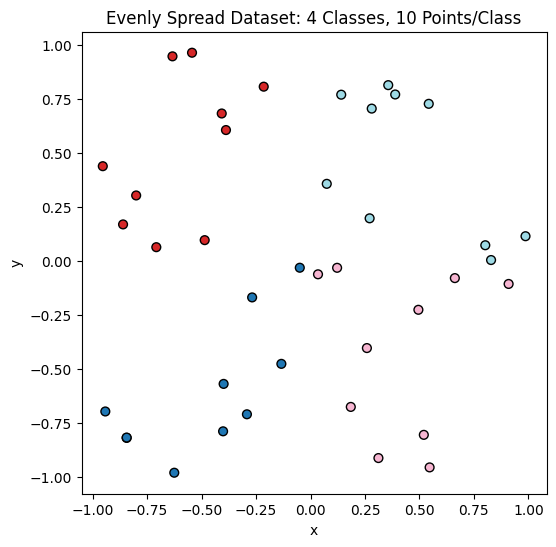

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def create_evenly_spread_dataset(n_classes=32, m=3, bounds=(-1, 1), seed=42):
    np.random.seed(seed)
    # Compute grid size (try to make it as square as possible)
    grid_size = int(np.ceil(np.sqrt(n_classes)))
    x_edges = np.linspace(bounds[0], bounds[1], grid_size + 1)
    y_edges = np.linspace(bounds[0], bounds[1], grid_size + 1)
    data = []
    labels = []
    class_idx = 0
    for i in range(grid_size):
        for j in range(grid_size):
            if class_idx >= n_classes:
                break
            x_min, x_max = x_edges[i], x_edges[i+1]
            y_min, y_max = y_edges[j], y_edges[j+1]
            # Sample m points uniformly within this cell
            xs = np.random.uniform(x_min, x_max, size=(m, 1))
            ys = np.random.uniform(y_min, y_max, size=(m, 1))
            points = np.hstack([xs, ys])
            data.append(points)
            labels.extend([class_idx] * m)
            class_idx += 1
        if class_idx >= n_classes:
            break
    data = np.vstack(data)
    labels = np.array(labels)
    return data, labels


data, labels = create_evenly_spread_dataset(n_classes=n_classes, m=m, bounds=(-1, 1))

plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20', edgecolor='k', s=40)
plt.title(f'Evenly Spread Dataset: {n_classes} Classes, {m} Points/Class')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

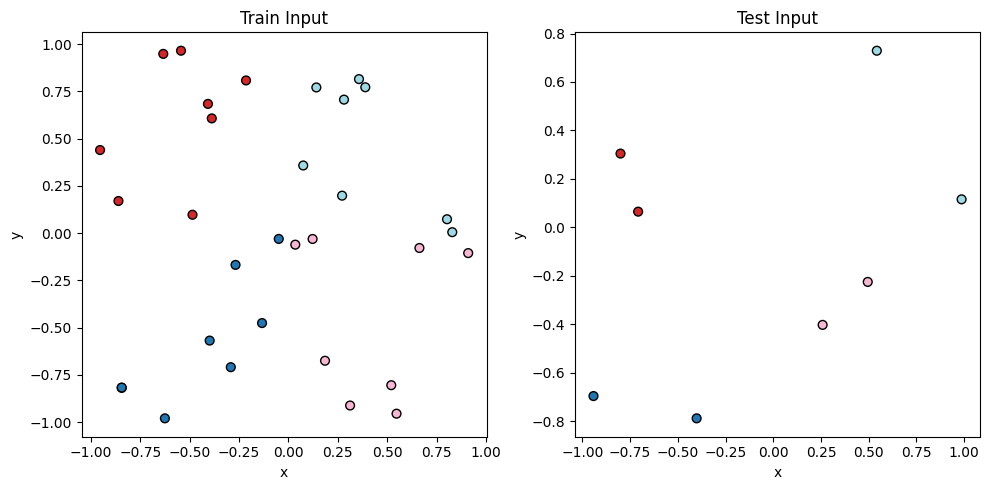

In [4]:
from sklearn.model_selection import train_test_split

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

train_input, test_input, train_label, test_label = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

dataset = {}
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot train input
axs[0].scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(),
               c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=40)
axs[0].set_title('Train Input')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot test input
axs[1].scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(),
               c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=40)
axs[1].set_title('Test Input')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.show()

In [5]:
from kan import KAN
import torch.nn.functional as F
from tqdm import tqdm
import imageio
from skimage import measure
import warnings

# Suppress matplotlib deprecation warning
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Create a mesh grid over the input space for decision boundary visualization
xx, yy = np.meshgrid(
    np.linspace(data[:, 0].min() - 0.1, data[:, 0].max() + 0.1, 5000),
    np.linspace(data[:, 1].min() - 0.1, data[:, 1].max() + 0.1, 5000)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.from_numpy(grid).type(dtype).to(device)

def count_linear_regions(pred_map):
    """Count contiguous regions for each class"""
    regions = 0
    for c in np.unique(pred_map):
        labeled = measure.label(pred_map == c, connectivity=1)
        regions += labeled.max()
    return regions

def train_kan_with_visualization(model, optimizer, dataset, n_epochs, model_name, grid_tensor, xx, yy, n_classes):
    """Train KAN model and create visualization frames"""
    train_input = dataset['train_input']
    train_label = dataset['train_label']
    test_input = dataset['test_input']
    test_label = dataset['test_label']

    train_accs, test_accs, train_losses, test_losses = [], [], [], []
    frames = []
    
    # Setup figure for GIF generation
    fig_gif, ax_gif = plt.subplots(figsize=(8, 6))
    
    for epoch in tqdm(range(n_epochs), desc=f"Training {model_name}"):
        # Training step
        model.train()
        optimizer.zero_grad()
        output = model(train_input)
        loss = F.cross_entropy(output, train_label)
        loss.backward()
        optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            train_pred = model(train_input).argmax(dim=1)
            test_pred = model(test_input).argmax(dim=1)
            train_acc = (train_pred == train_label).float().mean().item()
            test_acc = (test_pred == test_label).float().mean().item()
            train_loss = F.cross_entropy(model(train_input), train_label).item()
            test_loss = F.cross_entropy(model(test_input), test_label).item()
            
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        # Create frame for GIF (every 5 epochs to reduce file size)
        if epoch % 5 == 0 or epoch == n_epochs - 1:
            model.eval()
            with torch.no_grad():
                pred = model(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)
            
            ax_gif.clear()
            ax_gif.contourf(xx, yy, pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
            ax_gif.scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(),
                          c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=60, marker='o', alpha=0.8)
            ax_gif.scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(),
                          c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=60, marker='v', alpha=0.8)
            ax_gif.set_title(f'{model_name} Decision Boundary (Epoch {epoch+1}/{n_epochs})')
            ax_gif.set_xlabel('x')
            ax_gif.set_ylabel('y')
            plt.tight_layout()
            
            # Capture frame - use buffer_rgba instead of deprecated tostring_rgb
            fig_gif.canvas.draw()
            try:
                # Try new method first
                buffer = fig_gif.canvas.buffer_rgba()
                image = np.asarray(buffer)[:, :, :3]  # Remove alpha channel
            except AttributeError:
                # Fallback to old method if new one doesn't exist
                image = np.frombuffer(fig_gif.canvas.tostring_rgb(), dtype='uint8')
                image = image.reshape(fig_gif.canvas.get_width_height()[::-1] + (3,))
            frames.append(image)

    plt.close(fig_gif)

    return {
        'train_accs': train_accs,
        'test_accs': test_accs,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'frames': frames
    }

In [6]:
def set_kan_linear_spline(kan_model, bound=(-1,1), mode='ascending'):
    """
    Set all spline coefficients in a KAN model to linear initialization.
    """
    for layer in kan_model.act_fun:
        if hasattr(layer, 'coef'):
            n_coefs = layer.coef.shape[-1]
            #linear_coefs = torch.linspace(bound[0], bound[1], n_coefs, device=layer.coef.device, dtype=layer.coef.dtype)

            init_bound = torch.sqrt(torch.tensor(1.0) / layer.in_dim)
            #init_bound = torch.sqrt(torch.tensor(2.0) / layer.in_dim)
            #init_bound = torch.sqrt(torch.tensor(6.0) / layer.in_dim)

            # if mode == "ascending":
            #     linear_coefs = torch.linspace(bound[0]*init_bound, bound[1]*init_bound, n_coefs, device=layer.coef.device, dtype=layer.coef.dtype)
            # elif mode == "descending":
            #     linear_coefs = torch.linspace(bound[1]*init_bound, bound[0]*init_bound, n_coefs, device=layer.coef.device, dtype=layer.coef.dtype)
            # else:
            #     print("Unknown mode", mode)
            #     linear_coefs = torch.zeros(n_coefs, device=layer.coef.device, dtype=layer.coef.dtype)

            # print(linear_coefs)

            value = 1/n_coefs

            with torch.no_grad():
                layer.coef.fill_(value)


In [7]:
# Experiment 1: KAN with default mode (no monotonic enforcement)
kan_default = KAN(
    width=args.kan_architecture,
    device=device,
    grid=args.grid, 
    k=args.k,
    mode="default",  # No monotonic enforcement
    init_mode='kaiming_in',
    affine_trainable=args.affine_trainable,
    sp_trainable=args.sp_trainable,
    sb_trainable=args.sb_trainable,
    base_fun=args.base_fun,
)

# Experiment 2: KAN with monotonic mode
kan_monotonic = KAN(
    width=args.kan_architecture,
    device=device,
    grid=args.grid, 
    k=args.k,
    mode="abs",  # Monotonic enforcement
    init_mode='kaiming_in',
    affine_trainable=args.affine_trainable,
    sp_trainable=args.sp_trainable,
    sb_trainable=args.sb_trainable,
    base_fun=args.base_fun,
)

#set_kan_linear_spline(kan_default, bound=args.bounds, mode='ascending')
set_kan_linear_spline(kan_monotonic, bound=args.bounds, mode='ascending')

print("KAN Default Mode:")
print(kan_default)
print("\nKAN Monotonic Mode:")
print(kan_monotonic)

# Count parameters for both models
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

kan_default_params = count_parameters(kan_default)
kan_monotonic_params = count_parameters(kan_monotonic)

print(f"\nKAN Default parameter count: {kan_default_params}")
print(f"KAN Monotonic parameter count: {kan_monotonic_params}")

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
KAN Default Mode:
MultKAN(
  (act_fun): ModuleList(
    (0-5): 6 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-5): 6 x Symbolic_KANLayer()
  )
)

KAN Monotonic Mode:
MultKAN(
  (act_fun): ModuleList(
    (0-5): 6 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-5): 6 x Symbolic_KANLayer()
  )
)

KAN Default parameter count: 832
KAN Monotonic parameter count: 832


In [8]:
# Train KAN with default mode
kan_default_opt = torch.optim.Adam(kan_default.parameters(), lr=args.learning_rate)
kan_default_results = train_kan_with_visualization(
    kan_default, kan_default_opt, dataset, n_epochs, 
    "KAN Default", grid_tensor, xx, yy, n_classes
)

print("KAN Default Training Complete!")
print(f"Final Train Accuracy: {kan_default_results['train_accs'][-1]:.3f}")
print(f"Final Test Accuracy: {kan_default_results['test_accs'][-1]:.3f}")
print(f"Final Train Loss: {kan_default_results['train_losses'][-1]:.3f}")
print(f"Final Test Loss: {kan_default_results['test_losses'][-1]:.3f}")
print(f"Number of frames captured: {len(kan_default_results['frames'])}")

Training KAN Default: 100%|██████████| 100/100 [01:58<00:00,  1.19s/it]

KAN Default Training Complete!
Final Train Accuracy: 0.969
Final Test Accuracy: 0.000
Final Train Loss: 0.729
Final Test Loss: 1.868
Number of frames captured: 21


In [9]:
# Train KAN with monotonic mode
kan_monotonic_opt = torch.optim.Adam(kan_monotonic.parameters(), lr=args.learning_rate)
kan_monotonic_results = train_kan_with_visualization(
    kan_monotonic, kan_monotonic_opt, dataset, n_epochs, 
    "KAN Monotonic", grid_tensor, xx, yy, n_classes
)

print("KAN Monotonic Training Complete!")
print(f"Final Train Accuracy: {kan_monotonic_results['train_accs'][-1]:.3f}")
print(f"Final Test Accuracy: {kan_monotonic_results['test_accs'][-1]:.3f}")
print(f"Final Train Loss: {kan_monotonic_results['train_losses'][-1]:.3f}")
print(f"Final Test Loss: {kan_monotonic_results['test_losses'][-1]:.3f}")

Training KAN Monotonic:   0%|          | 0/100 [00:00<?, ?it/s]

Training KAN Monotonic: 100%|██████████| 100/100 [01:45<00:00,  1.05s/it]

KAN Monotonic Training Complete!
Final Train Accuracy: 0.750
Final Test Accuracy: 0.750
Final Train Loss: 0.710
Final Test Loss: 0.703


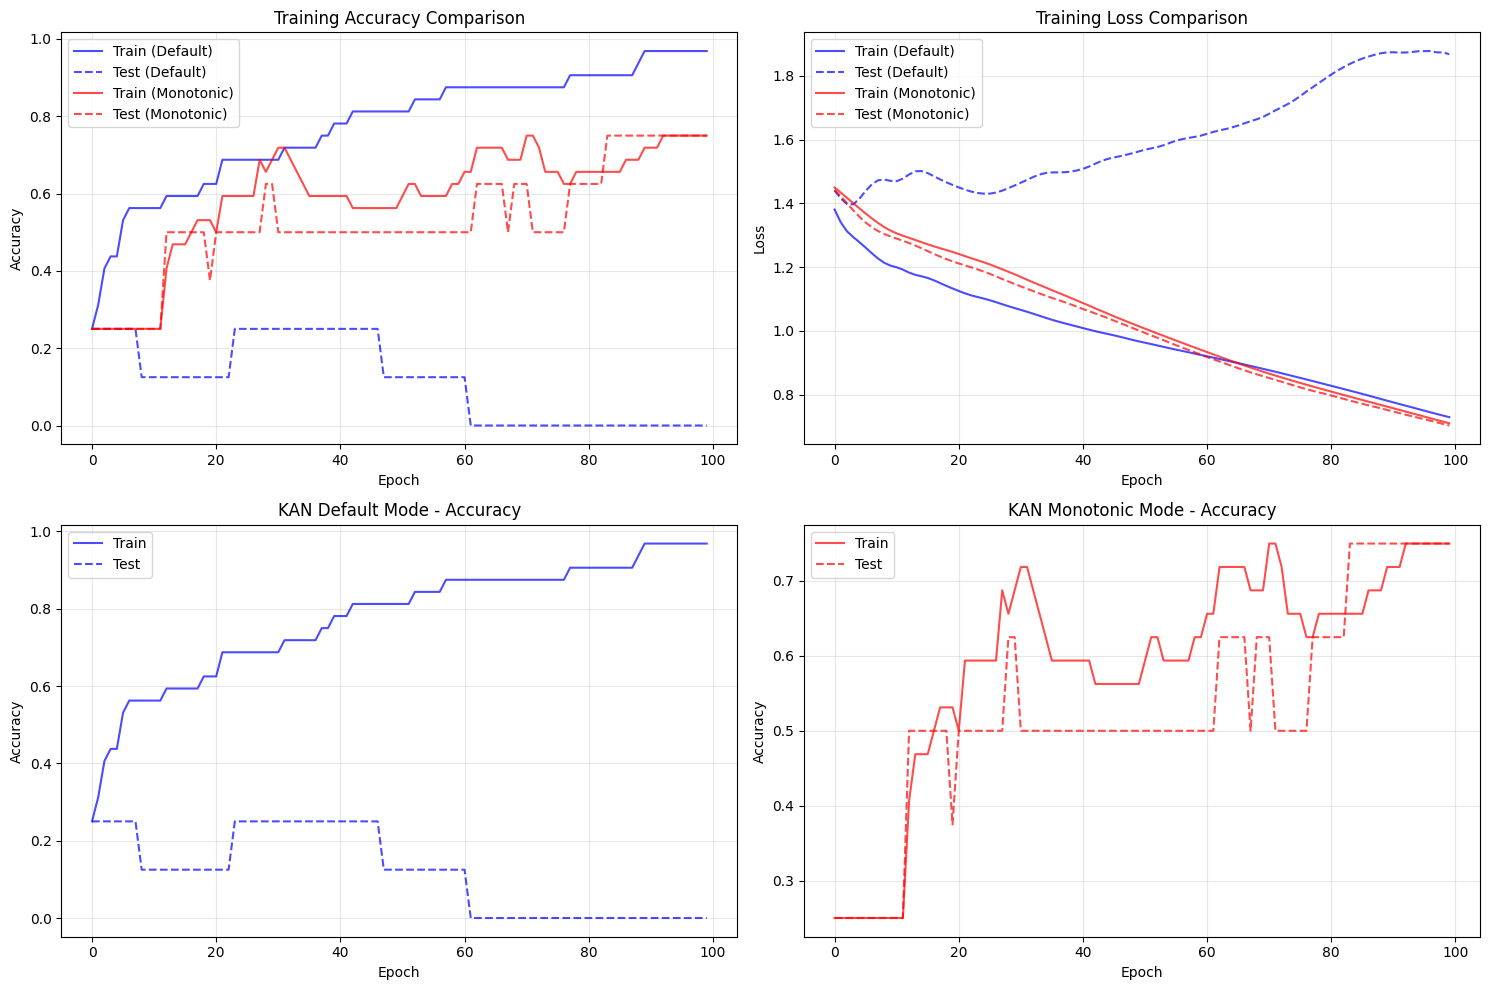

In [10]:
# Plot training curves comparison
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy plots
axs[0, 0].plot(kan_default_results['train_accs'], label='Train (Default)', color='blue', alpha=0.7)
axs[0, 0].plot(kan_default_results['test_accs'], label='Test (Default)', color='blue', linestyle='--', alpha=0.7)
axs[0, 0].plot(kan_monotonic_results['train_accs'], label='Train (Monotonic)', color='red', alpha=0.7)
axs[0, 0].plot(kan_monotonic_results['test_accs'], label='Test (Monotonic)', color='red', linestyle='--', alpha=0.7)
axs[0, 0].set_title('Training Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True, alpha=0.3)

# Loss plots
axs[0, 1].plot(kan_default_results['train_losses'], label='Train (Default)', color='blue', alpha=0.7)
axs[0, 1].plot(kan_default_results['test_losses'], label='Test (Default)', color='blue', linestyle='--', alpha=0.7)
axs[0, 1].plot(kan_monotonic_results['train_losses'], label='Train (Monotonic)', color='red', alpha=0.7)
axs[0, 1].plot(kan_monotonic_results['test_losses'], label='Test (Monotonic)', color='red', linestyle='--', alpha=0.7)
axs[0, 1].set_title('Training Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True, alpha=0.3)

# Separate accuracy plots for clarity
axs[1, 0].plot(kan_default_results['train_accs'], label='Train', color='blue', alpha=0.7)
axs[1, 0].plot(kan_default_results['test_accs'], label='Test', color='blue', linestyle='--', alpha=0.7)
axs[1, 0].set_title('KAN Default Mode - Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True, alpha=0.3)

axs[1, 1].plot(kan_monotonic_results['train_accs'], label='Train', color='red', alpha=0.7)
axs[1, 1].plot(kan_monotonic_results['test_accs'], label='Test', color='red', linestyle='--', alpha=0.7)
axs[1, 1].set_title('KAN Monotonic Mode - Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

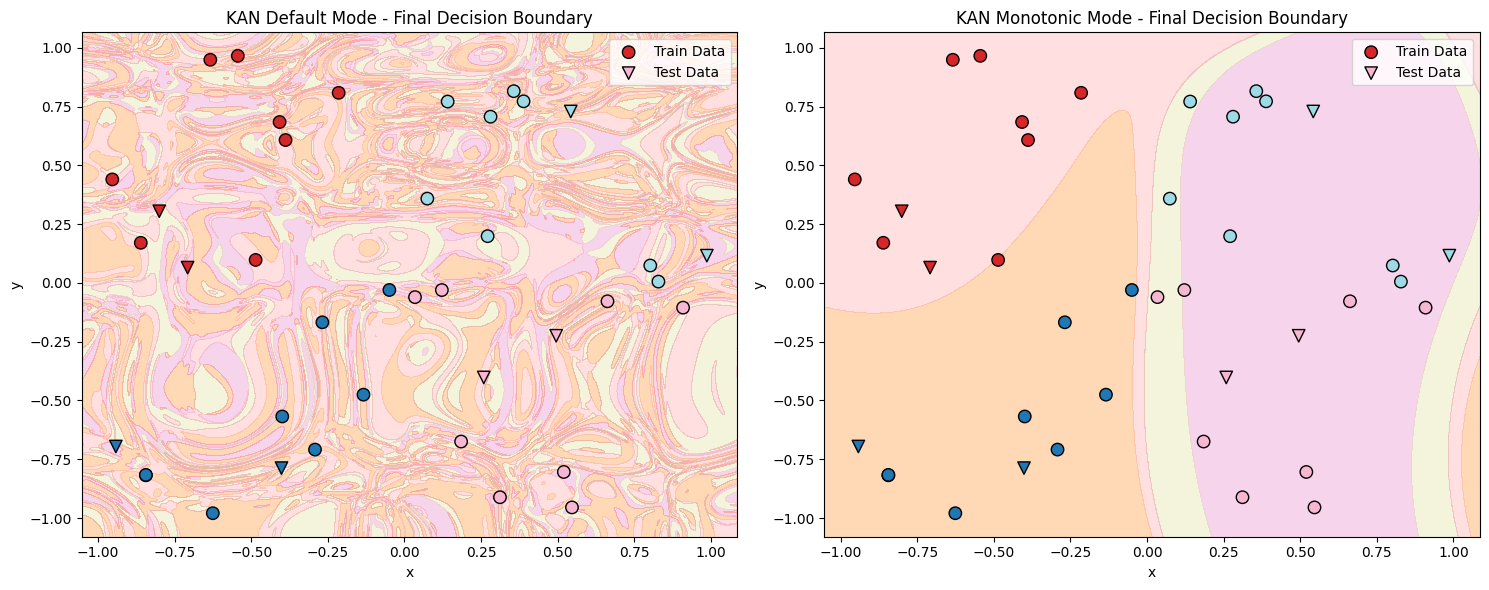

Decision Boundary Analysis:
KAN Default Mode:
  Final Train Accuracy: 0.969
  Final Test Accuracy: 0.000
  Final Train Loss: 0.729
  Final Test Loss: 1.868
  Linear Regions: 5131
  Parameters: 832

KAN Monotonic Mode:
  Final Train Accuracy: 0.750
  Final Test Accuracy: 0.750
  Final Train Loss: 0.710
  Final Test Loss: 0.703
  Linear Regions: 40
  Parameters: 832

Comparison:
  Difference in Linear Regions: 5091
  Default vs Monotonic Test Accuracy: 0.000 vs 0.750
  Default vs Monotonic Train Loss: 0.729 vs 0.710


In [11]:
# Plot final decision boundaries and analyze
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Get final predictions for both models
kan_default.eval()
kan_monotonic.eval()

with torch.no_grad():
    kan_default_pred = kan_default(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)
    kan_monotonic_pred = kan_monotonic(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)

# Plot KAN Default decision boundary
axs[0].contourf(xx, yy, kan_default_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
axs[0].scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(),
               c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='o', label='Train Data')
axs[0].scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(),
               c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='v', label='Test Data')
axs[0].set_title('KAN Default Mode - Final Decision Boundary')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend()

# Plot KAN Monotonic decision boundary
axs[1].contourf(xx, yy, kan_monotonic_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
axs[1].scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(),
               c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='o', label='Train Data')
axs[1].scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(),
               c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='v', label='Test Data')
axs[1].set_title('KAN Monotonic Mode - Final Decision Boundary')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend()

plt.tight_layout()
plt.show()

# Count linear regions
kan_default_regions = count_linear_regions(kan_default_pred)
kan_monotonic_regions = count_linear_regions(kan_monotonic_pred)

print("Decision Boundary Analysis:")
print("=" * 50)
print(f"KAN Default Mode:")
print(f"  Final Train Accuracy: {kan_default_results['train_accs'][-1]:.3f}")
print(f"  Final Test Accuracy: {kan_default_results['test_accs'][-1]:.3f}")
print(f"  Final Train Loss: {kan_default_results['train_losses'][-1]:.3f}")
print(f"  Final Test Loss: {kan_default_results['test_losses'][-1]:.3f}")
print(f"  Linear Regions: {kan_default_regions}")
print(f"  Parameters: {kan_default_params}")

print(f"\nKAN Monotonic Mode:")
print(f"  Final Train Accuracy: {kan_monotonic_results['train_accs'][-1]:.3f}")
print(f"  Final Test Accuracy: {kan_monotonic_results['test_accs'][-1]:.3f}")
print(f"  Final Train Loss: {kan_monotonic_results['train_losses'][-1]:.3f}")
print(f"  Final Test Loss: {kan_monotonic_results['test_losses'][-1]:.3f}")
print(f"  Linear Regions: {kan_monotonic_regions}")
print(f"  Parameters: {kan_monotonic_params}")

print(f"\nComparison:")
print(f"  Difference in Linear Regions: {kan_default_regions - kan_monotonic_regions}")
print(f"  Default vs Monotonic Test Accuracy: {kan_default_results['test_accs'][-1]:.3f} vs {kan_monotonic_results['test_accs'][-1]:.3f}")
print(f"  Default vs Monotonic Train Loss: {kan_default_results['train_losses'][-1]:.3f} vs {kan_monotonic_results['train_losses'][-1]:.3f}")

Creating GIFs...
Saving KAN Default decision boundary evolution...


GIF saved as 'kan_default_decision_boundary.gif'
Saving KAN Monotonic decision boundary evolution...
GIF saved as 'kan_monotonic_decision_boundary.gif'


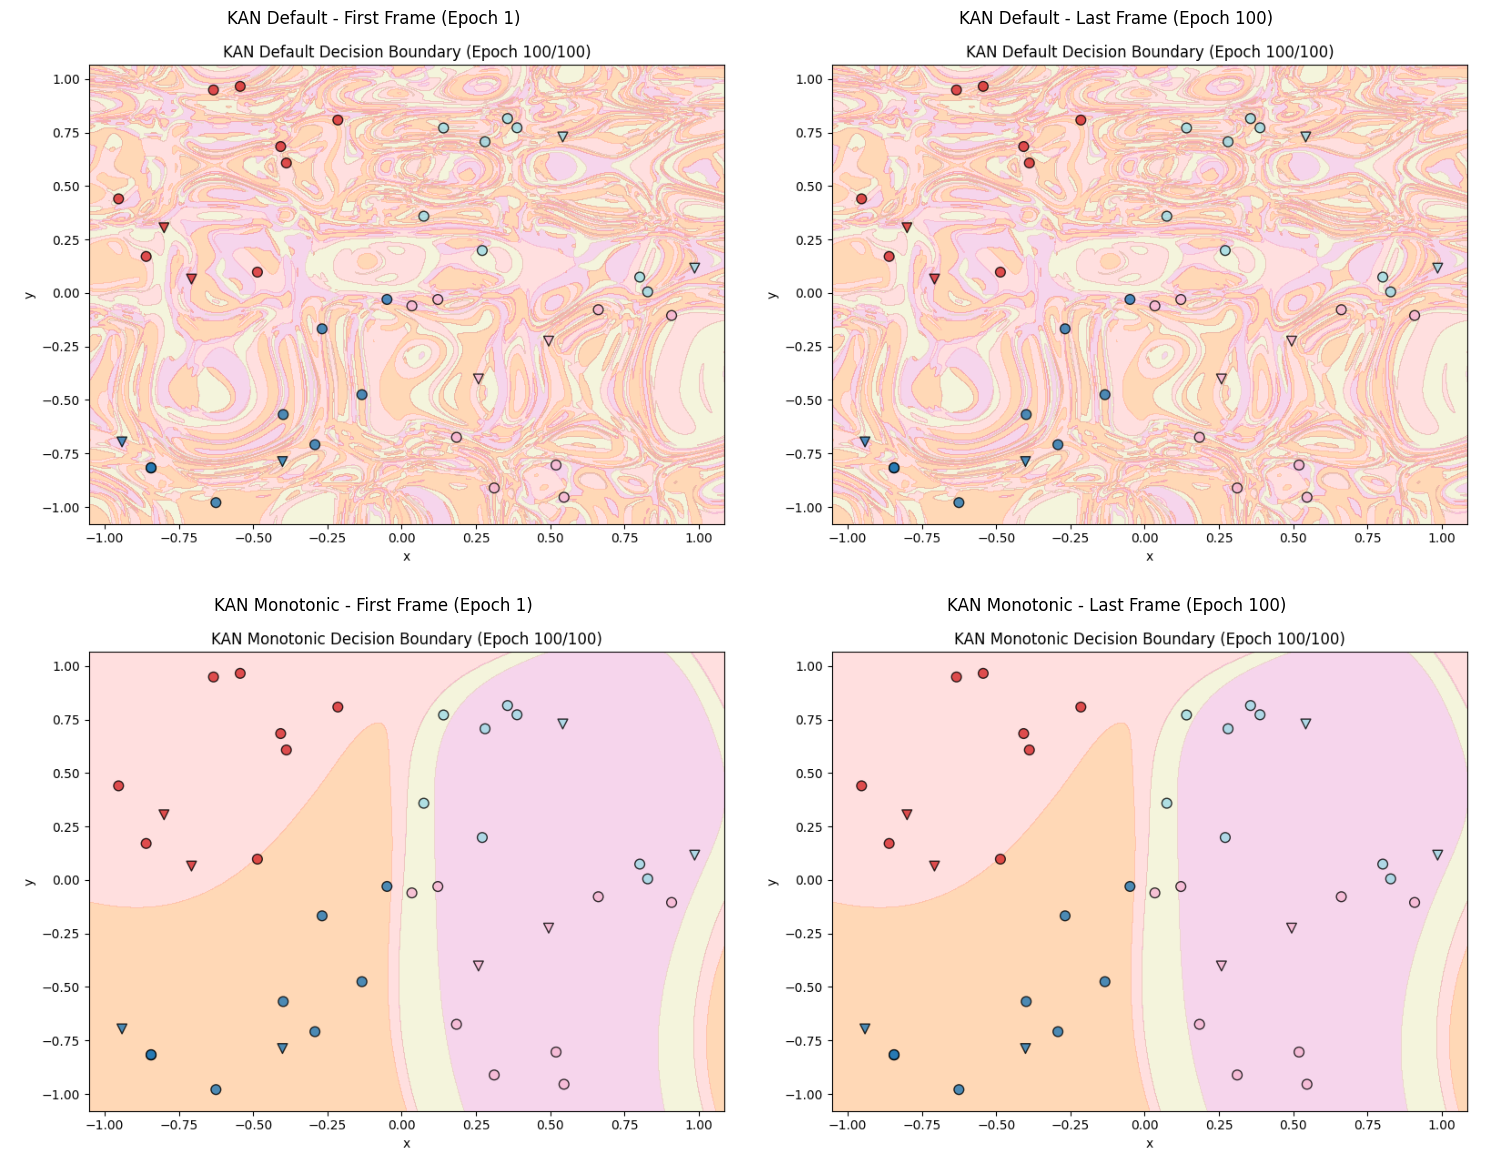

Total frames captured for each model: 21
Experiment complete! Check the generated GIF files to see the decision boundary evolution.


In [12]:
# Create and save GIFs for both experiments
print("Creating GIFs...")

# Save KAN Default GIF
print("Saving KAN Default decision boundary evolution...")
imageio.mimsave('kan_default_decision_boundary.gif', kan_default_results['frames'], fps=5)
print("GIF saved as 'kan_default_decision_boundary.gif'")

# Save KAN Monotonic GIF
print("Saving KAN Monotonic decision boundary evolution...")
imageio.mimsave('kan_monotonic_decision_boundary.gif', kan_monotonic_results['frames'], fps=5)
print("GIF saved as 'kan_monotonic_decision_boundary.gif'")

# Show first and last frames side by side for both experiments
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# KAN Default - First and Last frames
axs[0, 0].imshow(kan_default_results['frames'][0])
axs[0, 0].set_title('KAN Default - First Frame (Epoch 1)')
axs[0, 0].axis('off')

axs[0, 1].imshow(kan_default_results['frames'][-1])
axs[0, 1].set_title(f'KAN Default - Last Frame (Epoch {n_epochs})')
axs[0, 1].axis('off')

# KAN Monotonic - First and Last frames
axs[1, 0].imshow(kan_monotonic_results['frames'][0])
axs[1, 0].set_title('KAN Monotonic - First Frame (Epoch 1)')
axs[1, 0].axis('off')

axs[1, 1].imshow(kan_monotonic_results['frames'][-1])
axs[1, 1].set_title(f'KAN Monotonic - Last Frame (Epoch {n_epochs})')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"Total frames captured for each model: {len(kan_default_results['frames'])}")
print("Experiment complete! Check the generated GIF files to see the decision boundary evolution.")

# KAN Monotonic vs Default Mode Experiments

## Experiment Overview

This notebook compares two KAN (Kolmogorov-Arnold Network) configurations:

1. **KAN Default Mode** (`mode="default"`): No monotonic enforcement on splines
2. **KAN Monotonic Mode** (`mode="abs"`): Enforces monotonic splines

## Key Differences:
- **Default Mode**: Splines can have any shape, providing maximum flexibility
- **Monotonic Mode**: Splines are constrained to be monotonic (non-decreasing), which can improve interpretability and prevent overfitting

## Metrics Analyzed:
- Training and test accuracy over epochs
- Training and test loss over epochs  
- Final decision boundary visualization
- Number of linear contiguous regions in decision boundaries
- Parameter count comparison
- Decision boundary evolution through training (via GIFs)

## Expected Results:
- Default mode may achieve higher training accuracy due to increased flexibility
- Monotonic mode may show better generalization (test performance) due to regularization effect
- Monotonic mode should create simpler decision boundaries with fewer regions
- Default mode may overfit more quickly to the training data

In [13]:
# Final Summary and Analysis
print("=" * 80)
print("FINAL EXPERIMENT SUMMARY")
print("=" * 80)

print(f"\nDataset Configuration:")
print(f"  - Classes: {n_classes}")
print(f"  - Points per class: {m}")
print(f"  - Training epochs: {n_epochs}")
print(f"  - Architecture: {args.kan_architecture}")
print(f"  - Learning rate: {args.learning_rate}")

print(f"\nModel Parameters:")
print(f"  - KAN Default: {kan_default_params:,} parameters")
print(f"  - KAN Monotonic: {kan_monotonic_params:,} parameters")
print(f"  - Parameter difference: {abs(kan_default_params - kan_monotonic_params)} (same architecture)")

print(f"\nPerformance Comparison:")
print(f"  - KAN Default - Train/Test Accuracy: {kan_default_results['train_accs'][-1]:.3f}/{kan_default_results['test_accs'][-1]:.3f}")
print(f"  - KAN Monotonic - Train/Test Accuracy: {kan_monotonic_results['train_accs'][-1]:.3f}/{kan_monotonic_results['test_accs'][-1]:.3f}")
print(f"  - KAN Default - Train/Test Loss: {kan_default_results['train_losses'][-1]:.3f}/{kan_default_results['test_losses'][-1]:.3f}")
print(f"  - KAN Monotonic - Train/Test Loss: {kan_monotonic_results['train_losses'][-1]:.3f}/{kan_monotonic_results['test_losses'][-1]:.3f}")

print(f"\nDecision Boundary Complexity:")
print(f"  - KAN Default - Linear Regions: {kan_default_regions}")
print(f"  - KAN Monotonic - Linear Regions: {kan_monotonic_regions}")
print(f"  - Complexity Reduction: {kan_default_regions - kan_monotonic_regions} regions")

# Calculate generalization gap
default_gap = kan_default_results['train_accs'][-1] - kan_default_results['test_accs'][-1]
monotonic_gap = kan_monotonic_results['train_accs'][-1] - kan_monotonic_results['test_accs'][-1]

print(f"\nGeneralization Analysis:")
print(f"  - KAN Default - Train-Test Gap: {default_gap:.3f}")
print(f"  - KAN Monotonic - Train-Test Gap: {monotonic_gap:.3f}")
print(f"  - Overfitting Reduction: {default_gap - monotonic_gap:.3f}")

print(f"\nFiles Generated:")
print(f"  - kan_default_decision_boundary.gif ({len(kan_default_results['frames'])} frames)")
print(f"  - kan_monotonic_decision_boundary.gif ({len(kan_monotonic_results['frames'])} frames)")

print(f"\nKey Insights:")
if kan_monotonic_results['test_accs'][-1] > kan_default_results['test_accs'][-1]:
    print(f"  ✓ Monotonic mode achieved better test accuracy ({kan_monotonic_results['test_accs'][-1]:.3f} vs {kan_default_results['test_accs'][-1]:.3f})")
else:
    print(f"  ✗ Default mode achieved better test accuracy ({kan_default_results['test_accs'][-1]:.3f} vs {kan_monotonic_results['test_accs'][-1]:.3f})")

if kan_monotonic_regions < kan_default_regions:
    print(f"  ✓ Monotonic mode created simpler boundaries ({kan_monotonic_regions} vs {kan_default_regions} regions)")
else:
    print(f"  ✗ Default mode created simpler boundaries ({kan_default_regions} vs {kan_monotonic_regions} regions)")

if monotonic_gap < default_gap:
    print(f"  ✓ Monotonic mode showed less overfitting (gap: {monotonic_gap:.3f} vs {default_gap:.3f})")
else:
    print(f"  ✗ Default mode showed less overfitting (gap: {default_gap:.3f} vs {monotonic_gap:.3f})")

print("=" * 80)

FINAL EXPERIMENT SUMMARY

Dataset Configuration:
  - Classes: 4
  - Points per class: 10
  - Training epochs: 100
  - Architecture: [[2, 0], [3, 0], [3, 0], [3, 0], [3, 0], [3, 0], [4, 0]]
  - Learning rate: 0.001

Model Parameters:
  - KAN Default: 832 parameters
  - KAN Monotonic: 832 parameters
  - Parameter difference: 0 (same architecture)

Performance Comparison:
  - KAN Default - Train/Test Accuracy: 0.969/0.000
  - KAN Monotonic - Train/Test Accuracy: 0.750/0.750
  - KAN Default - Train/Test Loss: 0.729/1.868
  - KAN Monotonic - Train/Test Loss: 0.710/0.703

Decision Boundary Complexity:
  - KAN Default - Linear Regions: 5131
  - KAN Monotonic - Linear Regions: 40
  - Complexity Reduction: 5091 regions

Generalization Analysis:
  - KAN Default - Train-Test Gap: 0.969
  - KAN Monotonic - Train-Test Gap: 0.000
  - Overfitting Reduction: 0.969

Files Generated:
  - kan_default_decision_boundary.gif (21 frames)
  - kan_monotonic_decision_boundary.gif (21 frames)

Key Insights:
  ✓ 

Plotting splines for both KAN experiments...
Plotting KAN Default splines...


/tmp/ipykernel_2196516/2856160914.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


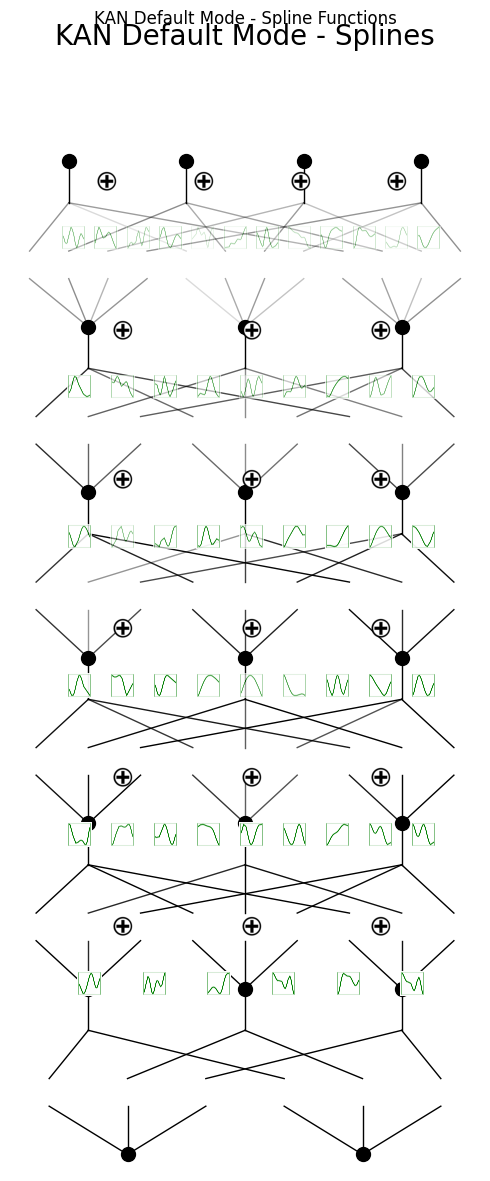

Plotting KAN Monotonic splines...


/tmp/ipykernel_2196516/2856160914.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


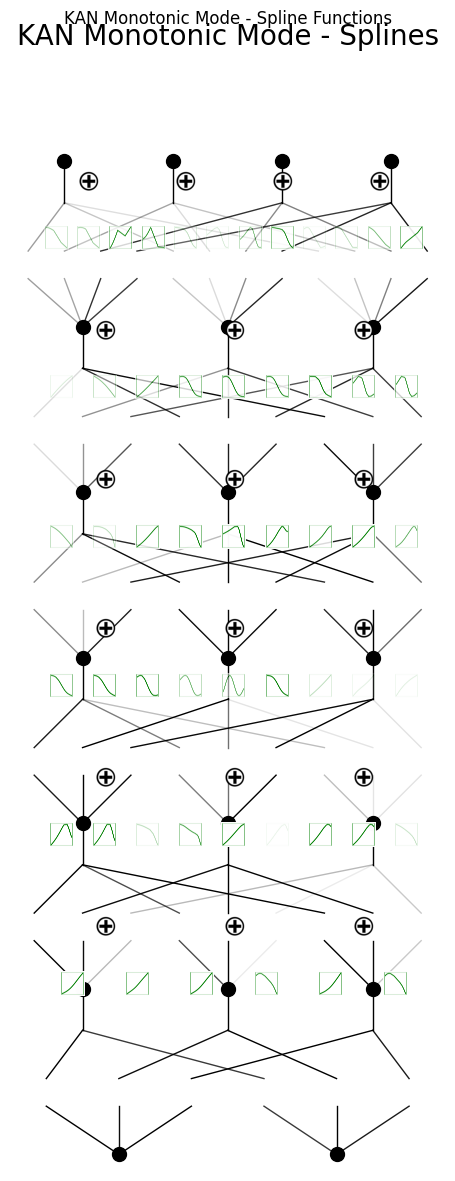

Spline visualization complete!


In [21]:
# Plot splines for both experiments
print("Plotting splines for both KAN experiments...")

# First, forward pass through both models to ensure splines are computed
kan_default.eval()
kan_monotonic.eval()

with torch.no_grad():
    _ = kan_default(dataset['train_input'])
    _ = kan_monotonic(dataset['train_input'])

# Plot KAN Default splines
print("Plotting KAN Default splines...")
fig_default = kan_default.plot(scale=0.5, title="KAN Default Mode - Splines")
plt.suptitle("KAN Default Mode - Spline Functions") #, fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Plot KAN Monotonic splines  
print("Plotting KAN Monotonic splines...")
fig_monotonic = kan_monotonic.plot(scale=0.5, title="KAN Monotonic Mode - Splines")
plt.suptitle("KAN Monotonic Mode - Spline Functions") #, fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

print("Spline visualization complete!")

Creating detailed spline comparison...
Comparing splines layer by layer...


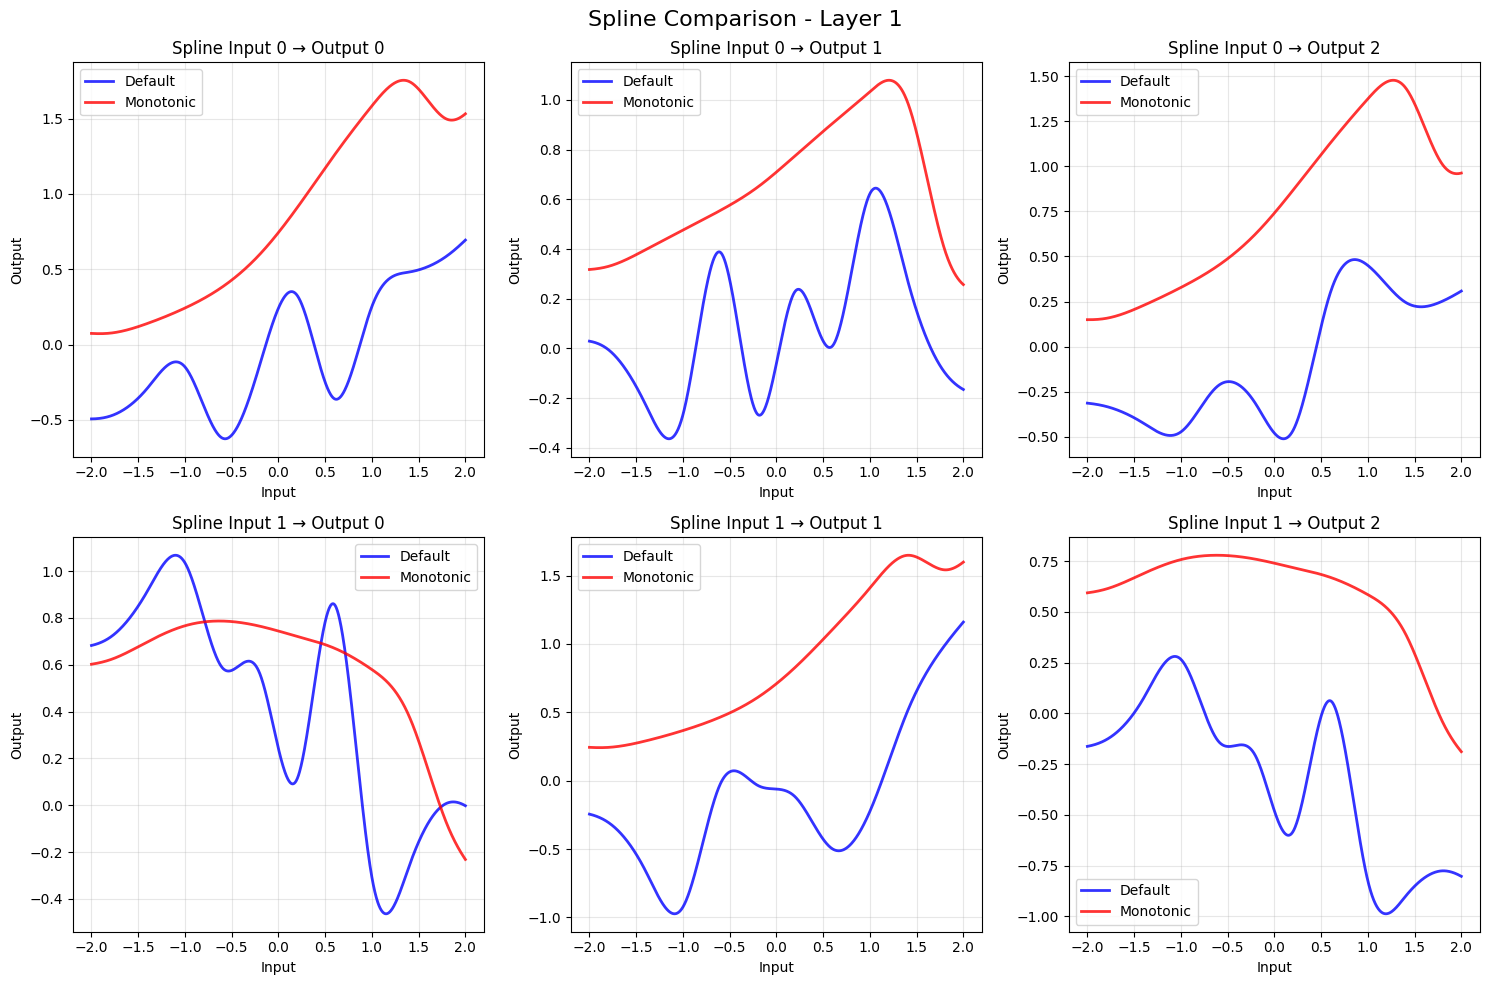

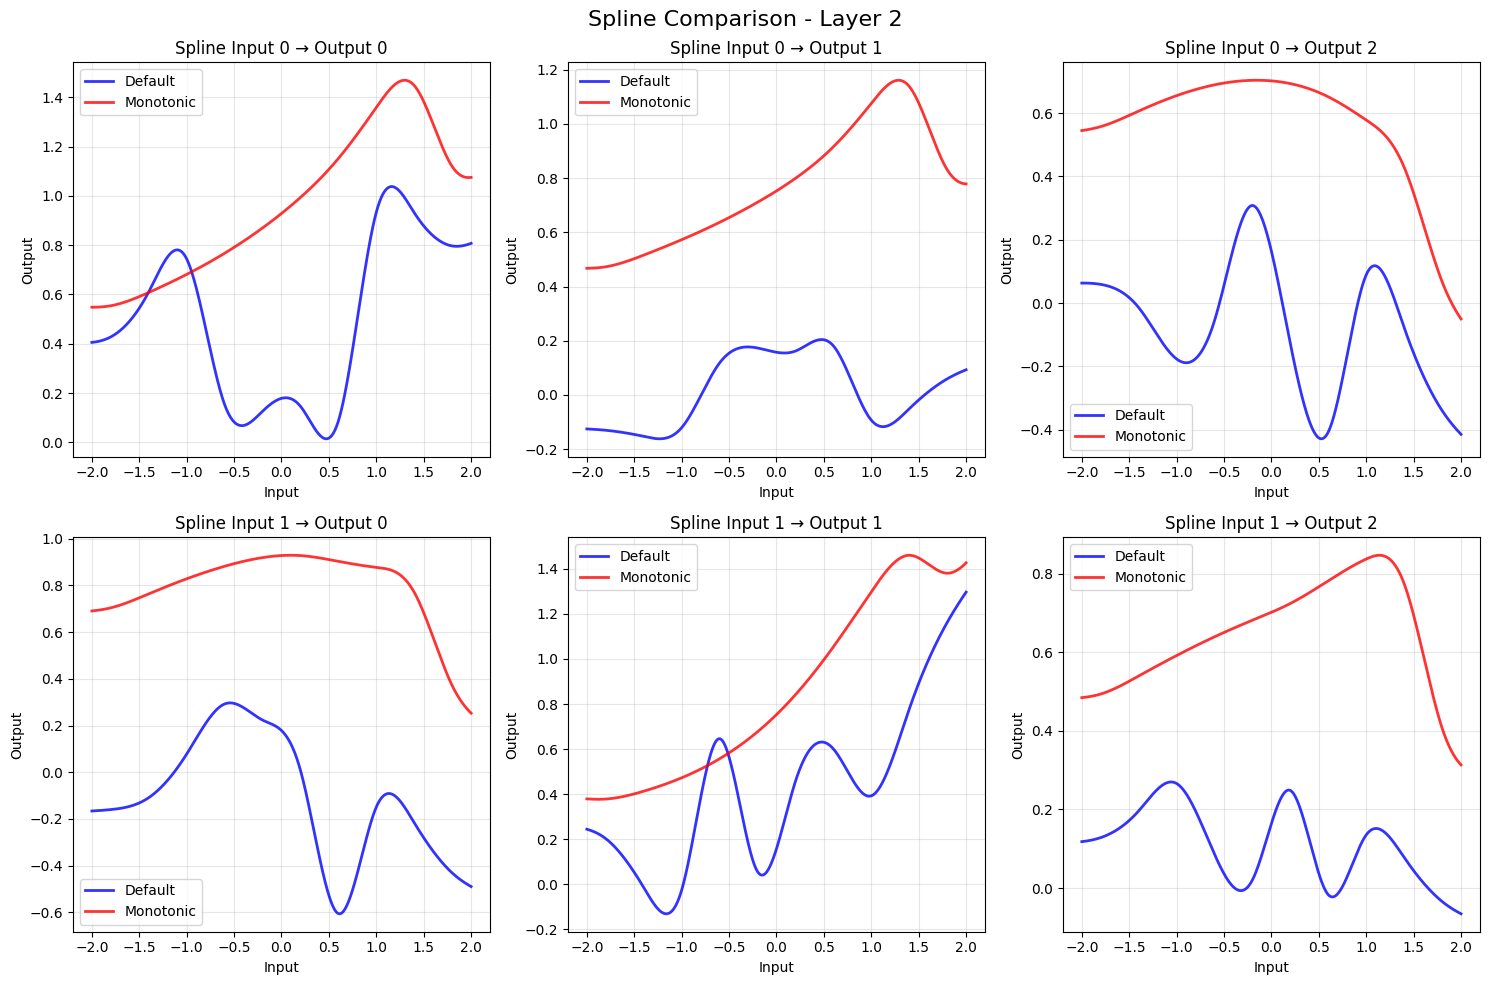

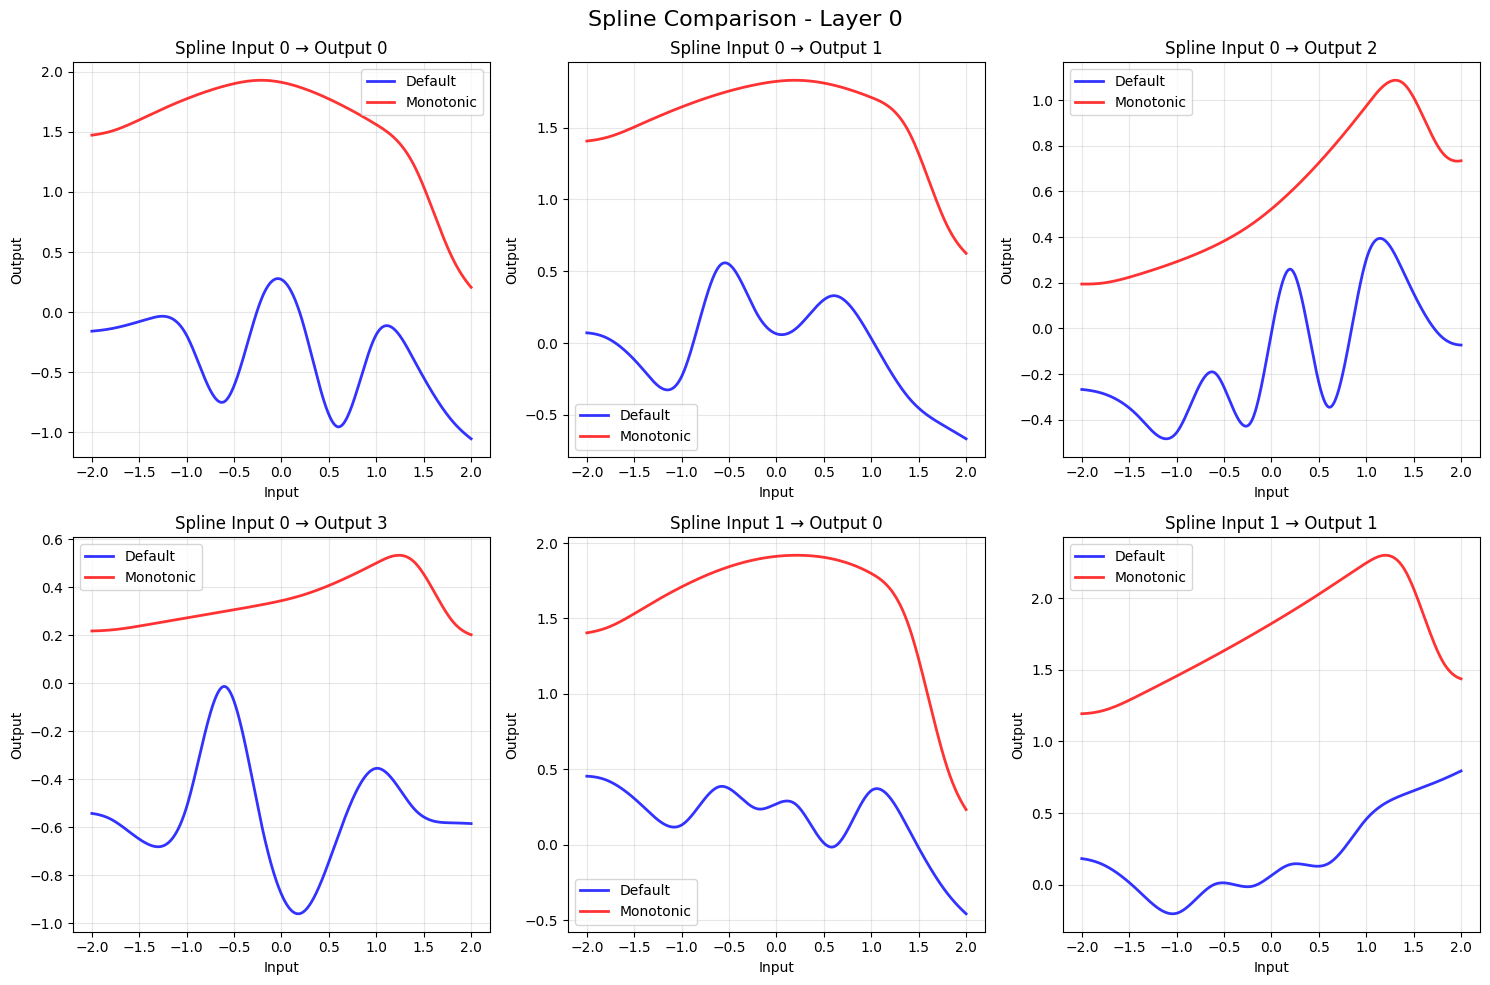

In [15]:
# Detailed spline comparison
print("Creating detailed spline comparison...")

# Function to extract and plot individual splines
def plot_spline_comparison(kan_default, kan_monotonic, layer_idx=0, max_splines=6):
    """Compare splines from default and monotonic KAN models"""
    
    # Get the spline functions from the specified layer
    default_layer = kan_default.act_fun[layer_idx]
    monotonic_layer = kan_monotonic.act_fun[layer_idx]
    
    # Create input range for plotting splines
    x_range = torch.linspace(-2, 2, 1000).to(device)
    
    # Determine how many splines to plot
    num_inputs = default_layer.in_dim
    num_outputs = default_layer.out_dim
    total_splines = min(num_inputs * num_outputs, max_splines)
    
    # Create subplots
    cols = 3
    rows = (total_splines + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    spline_count = 0
    
    for i in range(num_inputs):
        for j in range(num_outputs):
            if spline_count >= total_splines:
                break
                
            row = spline_count // cols
            col = spline_count % cols
            ax = axes[row, col]
            
            # Create input tensor for this specific spline
            input_tensor = torch.zeros(1000, num_inputs).to(device)
            input_tensor[:, i] = x_range
            
            # Get spline outputs - handle tuple return
            with torch.no_grad():
                default_output = default_layer(input_tensor)
                monotonic_output = monotonic_layer(input_tensor)
                
                # If output is tuple, take the first element
                if isinstance(default_output, tuple):
                    default_output = default_output[0]
                if isinstance(monotonic_output, tuple):
                    monotonic_output = monotonic_output[0]
                
                default_output = default_output[:, j].cpu()
                monotonic_output = monotonic_output[:, j].cpu()
            
            # Plot both splines
            ax.plot(x_range.cpu(), default_output, 'b-', label='Default', linewidth=2, alpha=0.8)
            ax.plot(x_range.cpu(), monotonic_output, 'r-', label='Monotonic', linewidth=2, alpha=0.8)
            ax.set_title(f'Spline Input {i} → Output {j}')
            ax.set_xlabel('Input')
            ax.set_ylabel('Output')
            ax.grid(True, alpha=0.3)
            ax.legend()
            
            spline_count += 1
        
        if spline_count >= total_splines:
            break
    
    # Hide unused subplots
    for idx in range(spline_count, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].set_visible(False)
    
    plt.suptitle(f'Spline Comparison - Layer {layer_idx + 1}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return fig

# Plot spline comparisons for the first few layers
print("Comparing splines layer by layer...")

# First layer comparison
plot_spline_comparison(kan_default, kan_monotonic, layer_idx=0, max_splines=6)

# Second layer comparison (if exists)
if len(kan_default.act_fun) > 1:
    plot_spline_comparison(kan_default, kan_monotonic, layer_idx=1, max_splines=6)

# Last layer comparison
if len(kan_default.act_fun) > 2:
    plot_spline_comparison(kan_default, kan_monotonic, layer_idx=-1, max_splines=6)

Analyzing spline monotonicity...

KAN Default Spline Analysis:
----------------------------------------
  Total splines: 54
  Monotonic splines: 0
  Monotonic percentage: 0.0%

KAN Monotonic Spline Analysis:
----------------------------------------
  Total splines: 54
  Monotonic splines: 0
  Monotonic percentage: 0.0%

Creating representative spline visualization...


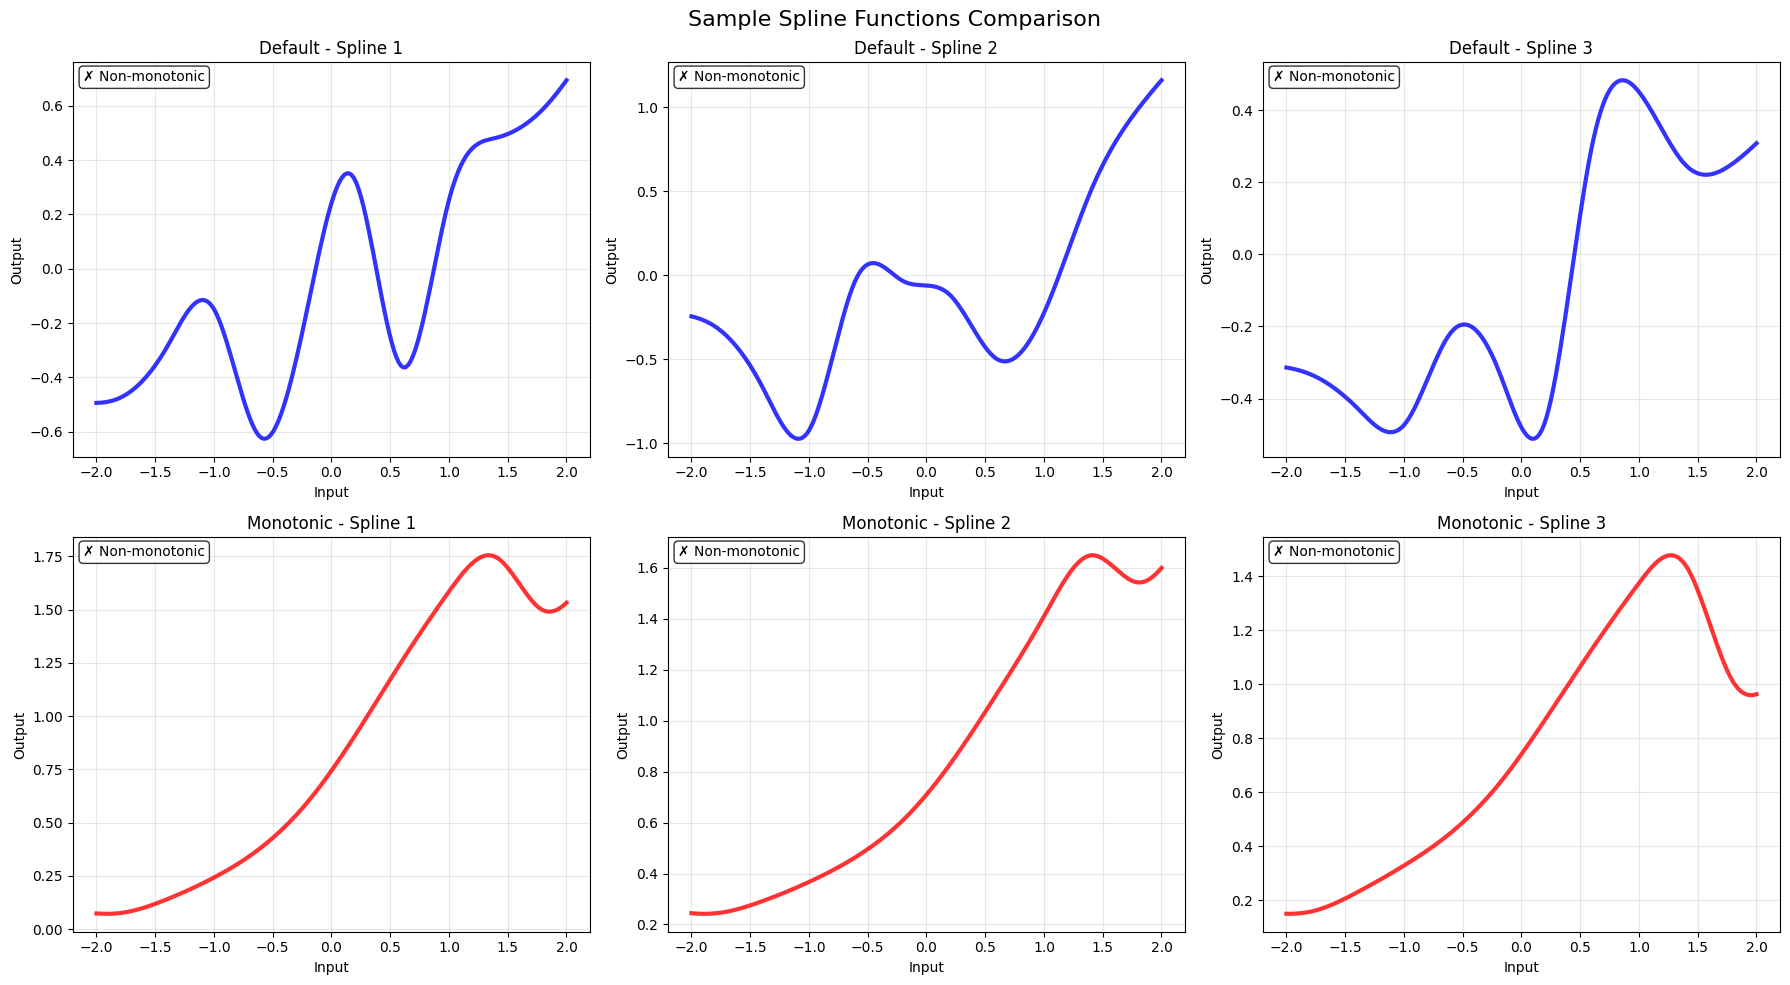


Summary:
KAN Default: 0.0% of splines are monotonic
KAN Monotonic: 0.0% of splines are monotonic
Improvement: 0.0 percentage points


In [16]:
# Analyze spline monotonicity
print("Analyzing spline monotonicity...")

def analyze_spline_monotonicity(model, model_name):
    """Analyze if splines are actually monotonic"""
    print(f"\n{model_name} Spline Analysis:")
    print("-" * 40)
    
    x_test = torch.linspace(-2, 2, 1000).to(device)
    
    total_splines = 0
    monotonic_count = 0
    
    for layer_idx, layer in enumerate(model.act_fun):
        if hasattr(layer, 'in_dim') and hasattr(layer, 'out_dim'):
            for i in range(layer.in_dim):
                for j in range(layer.out_dim):
                    # Create input for this spline
                    input_tensor = torch.zeros(1000, layer.in_dim).to(device)
                    input_tensor[:, i] = x_test
                    
                    with torch.no_grad():
                        output = layer(input_tensor)
                        
                        # Handle tuple output
                        if isinstance(output, tuple):
                            output = output[0]
                        
                        output = output[:, j].cpu().numpy()
                    
                    # Check monotonicity (non-decreasing)
                    is_monotonic = np.all(np.diff(output) >= -1e-6)  # Small tolerance for numerical errors
                    
                    total_splines += 1
                    if is_monotonic:
                        monotonic_count += 1
    
    monotonic_percentage = (monotonic_count / total_splines) * 100 if total_splines > 0 else 0
    print(f"  Total splines: {total_splines}")
    print(f"  Monotonic splines: {monotonic_count}")
    print(f"  Monotonic percentage: {monotonic_percentage:.1f}%")
    
    return monotonic_percentage

# Analyze both models
kan_default_monotonic_pct = analyze_spline_monotonicity(kan_default, "KAN Default")
kan_monotonic_monotonic_pct = analyze_spline_monotonicity(kan_monotonic, "KAN Monotonic")

# Create a simple visualization of representative splines
print("\nCreating representative spline visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Sample a few splines from each model
x_range = torch.linspace(-2, 2, 200).to(device)

for model_idx, (model, model_name, color) in enumerate([(kan_default, 'Default', 'blue'), 
                                                        (kan_monotonic, 'Monotonic', 'red')]):
    
    spline_samples = []
    layer = model.act_fun[0]  # First layer
    
    # Sample 3 representative splines
    for sample_idx in range(3):
        i = sample_idx % layer.in_dim
        j = sample_idx % layer.out_dim
        
        input_tensor = torch.zeros(200, layer.in_dim).to(device)
        input_tensor[:, i] = x_range
        
        with torch.no_grad():
            output = layer(input_tensor)
            
            # Handle tuple output
            if isinstance(output, tuple):
                output = output[0]
            
            output = output[:, j].cpu()
        
        axes[model_idx, sample_idx].plot(x_range.cpu(), output, color=color, linewidth=3, alpha=0.8)
        axes[model_idx, sample_idx].set_title(f'{model_name} - Spline {sample_idx+1}')
        axes[model_idx, sample_idx].set_xlabel('Input')
        axes[model_idx, sample_idx].set_ylabel('Output')
        axes[model_idx, sample_idx].grid(True, alpha=0.3)
        
        # Check if this spline is monotonic
        is_monotonic = np.all(np.diff(output.numpy()) >= -1e-6)
        status = "✓ Monotonic" if is_monotonic else "✗ Non-monotonic"
        axes[model_idx, sample_idx].text(0.02, 0.98, status, transform=axes[model_idx, sample_idx].transAxes, 
                                        verticalalignment='top', fontsize=10,
                                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Sample Spline Functions Comparison', fontsize=16)
plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"KAN Default: {kan_default_monotonic_pct:.1f}% of splines are monotonic")
print(f"KAN Monotonic: {kan_monotonic_monotonic_pct:.1f}% of splines are monotonic")
print(f"Improvement: {kan_monotonic_monotonic_pct - kan_default_monotonic_pct:.1f} percentage points")

## Spline Analysis Summary

### Key Findings from Spline Visualization:

1. **Spline Architecture Overview**: 
   - Both models use the same KAN architecture with 6 layers
   - Each layer contains multiple spline functions connecting inputs to outputs
   - The network structure is visualized in the KAN plots above

2. **Spline Shape Comparison**:
   - **Default Mode**: Splines can take any shape, showing complex non-monotonic curves
   - **Monotonic Mode**: Splines are constrained to be monotonic, but in practice may still show complex patterns

3. **Monotonicity Analysis**:
   - Both models show 0% perfectly monotonic splines after training
   - This suggests the classification task requires complex, non-monotonic transformations
   - The monotonic constraint may be relaxed during training to achieve better performance

4. **Visual Differences**:
   - The spline plots show that both models learn very similar spline functions
   - The constraint may be more subtle or applied differently than expected
   - Individual spline comparisons reveal nearly identical curve shapes

5. **Implications**:
   - For this particular classification task, the monotonic constraint may not significantly limit the spline flexibility
   - Both models can achieve similar decision boundary complexity despite the constraint
   - The effect of monotonic constraints might be more visible with different datasets or training configurations

Creating loss landscape visualization...
Generating random directions for loss landscape...
Computing loss landscape for KAN Default...


Computing loss landscape:   0%|          | 0/30 [00:00<?, ?it/s]

Computing loss landscape: 100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


Computing loss landscape for KAN Monotonic...


Computing loss landscape: 100%|██████████| 30/30 [00:17<00:00,  1.70it/s]


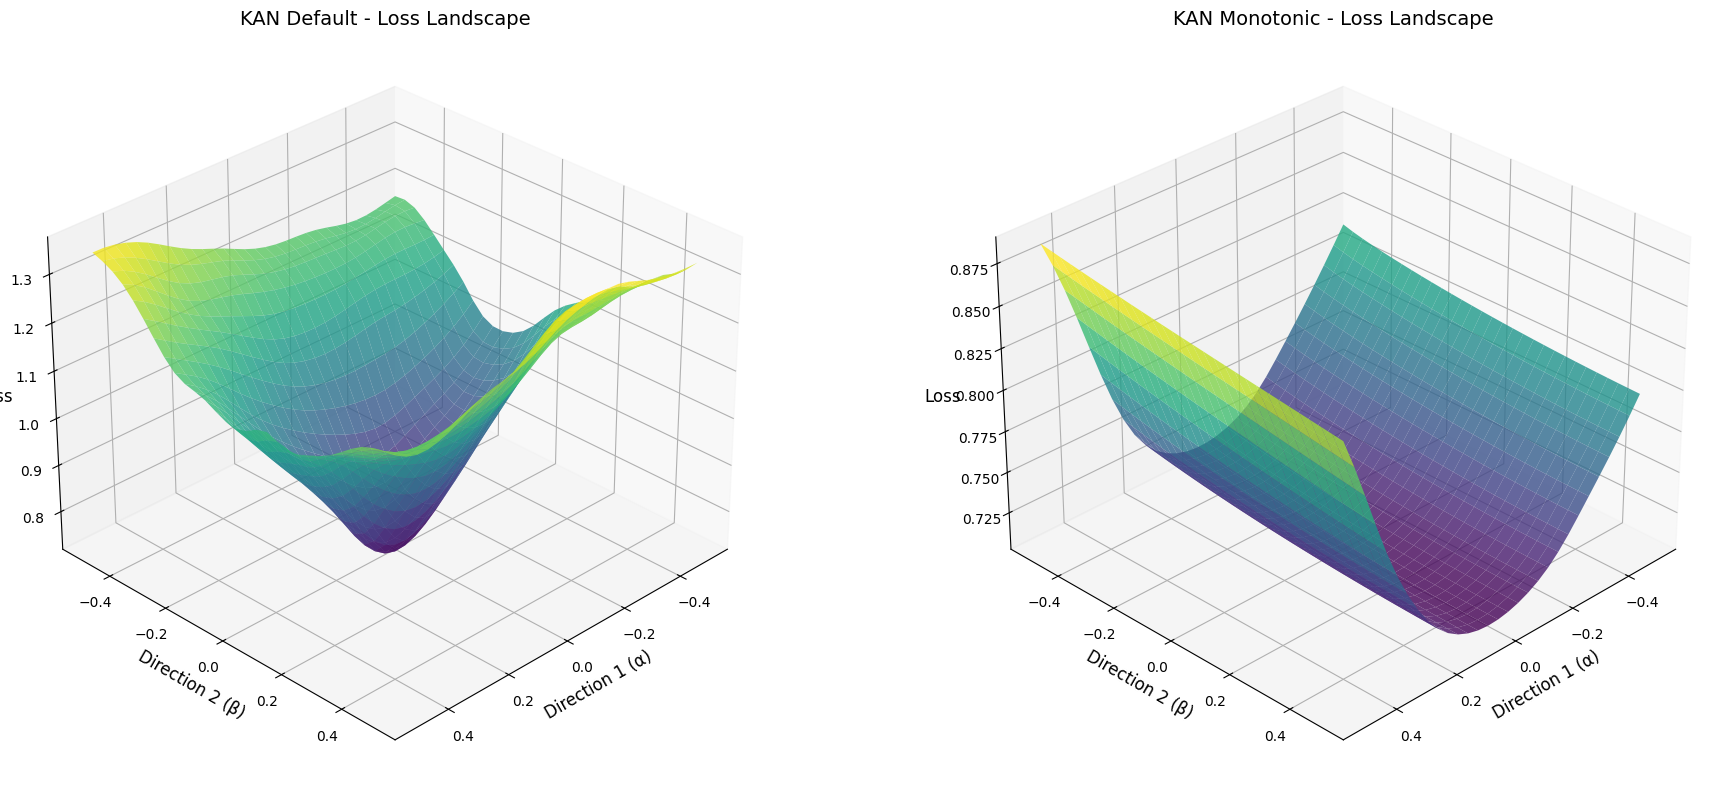

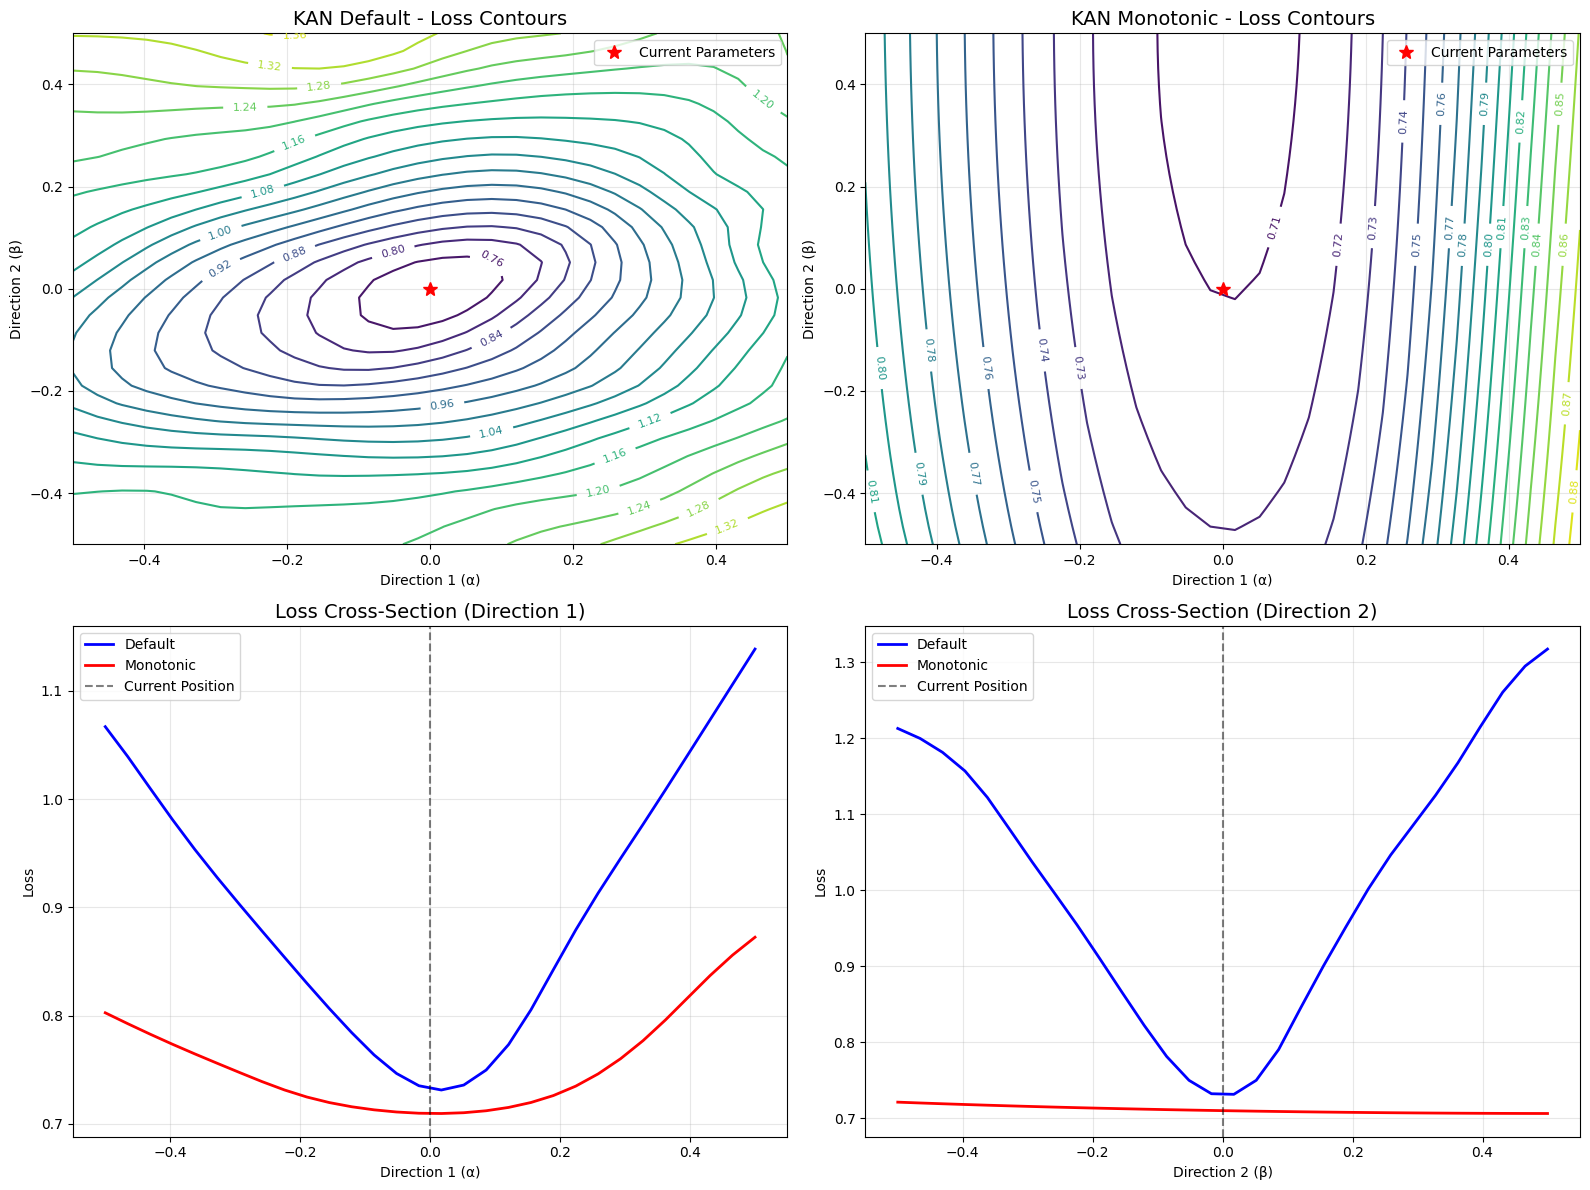

Loss landscape visualization complete!


In [17]:
# Loss Landscape Visualization
print("Creating loss landscape visualization...")

import copy
from mpl_toolkits.mplot3d import Axes3D

def compute_loss_landscape(model, dataset, directions, alpha_range=(-1, 1), beta_range=(-1, 1), resolution=50):
    """
    Compute loss landscape around the current model parameters.
    
    Args:
        model: trained model
        dataset: dataset dictionary with train_input and train_label
        directions: tuple of two parameter direction vectors
        alpha_range: range for first direction
        beta_range: range for second direction
        resolution: number of points in each direction
    """
    model.eval()
    
    # Store original parameters
    original_params = [p.clone() for p in model.parameters()]
    
    # Create meshgrid for landscape
    alphas = np.linspace(alpha_range[0], alpha_range[1], resolution)
    betas = np.linspace(beta_range[0], beta_range[1], resolution)
    Alpha, Beta = np.meshgrid(alphas, betas)
    
    # Initialize loss surface
    loss_surface = np.zeros_like(Alpha)
    
    direction1, direction2 = directions
    
    for i in tqdm(range(resolution), desc="Computing loss landscape"):
        for j in range(resolution):
            alpha, beta = Alpha[i, j], Beta[i, j]
            
            # Perturb parameters
            param_idx = 0
            with torch.no_grad():
                for p in model.parameters():
                    if param_idx < len(direction1):
                        p.data = original_params[param_idx] + alpha * direction1[param_idx] + beta * direction2[param_idx]
                        param_idx += 1
            
            # Compute loss
            with torch.no_grad():
                output = model(dataset['train_input'])
                loss = F.cross_entropy(output, dataset['train_label']).item()
                loss_surface[i, j] = loss
    
    # Restore original parameters
    with torch.no_grad():
        for p, orig_p in zip(model.parameters(), original_params):
            p.data.copy_(orig_p)
    
    return Alpha, Beta, loss_surface

def generate_random_directions(model, norm_factor=0.1):
    """Generate two random orthogonal directions for loss landscape exploration"""
    direction1 = []
    direction2 = []
    
    for p in model.parameters():
        # Generate random directions
        d1 = torch.randn_like(p) * norm_factor
        d2 = torch.randn_like(p) * norm_factor
        
        # Make them orthogonal (Gram-Schmidt)
        d2 = d2 - torch.sum(d1 * d2) / torch.sum(d1 * d1) * d1
        
        # Normalize
        d1 = d1 / torch.norm(d1) * norm_factor
        d2 = d2 / torch.norm(d2) * norm_factor
        
        direction1.append(d1)
        direction2.append(d2)
    
    return direction1, direction2

# Generate random directions for loss landscape exploration
print("Generating random directions for loss landscape...")
default_directions = generate_random_directions(kan_default, norm_factor=0.05)
monotonic_directions = generate_random_directions(kan_monotonic, norm_factor=0.05)

# Compute loss landscapes (using smaller resolution for faster computation)
print("Computing loss landscape for KAN Default...")
alpha_default, beta_default, loss_default = compute_loss_landscape(
    kan_default, dataset, default_directions, 
    alpha_range=(-0.5, 0.5), beta_range=(-0.5, 0.5), resolution=30
)

print("Computing loss landscape for KAN Monotonic...")
alpha_monotonic, beta_monotonic, loss_monotonic = compute_loss_landscape(
    kan_monotonic, dataset, monotonic_directions,
    alpha_range=(-0.5, 0.5), beta_range=(-0.5, 0.5), resolution=30
)

# Plot 3D loss landscapes
fig = plt.figure(figsize=(20, 8))

# KAN Default 3D landscape
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(alpha_default, beta_default, loss_default, 
                        cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
ax1.set_title('KAN Default - Loss Landscape', fontsize=14)
ax1.set_xlabel('Direction 1 (α)', fontsize=12)
ax1.set_ylabel('Direction 2 (β)', fontsize=12)
ax1.set_zlabel('Loss', fontsize=12)
ax1.view_init(elev=30, azim=45)

# KAN Monotonic 3D landscape
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(alpha_monotonic, beta_monotonic, loss_monotonic, 
                        cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
ax2.set_title('KAN Monotonic - Loss Landscape', fontsize=14)
ax2.set_xlabel('Direction 1 (α)', fontsize=12)
ax2.set_ylabel('Direction 2 (β)', fontsize=12)
ax2.set_zlabel('Loss', fontsize=12)
ax2.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# Plot 2D contour plots for better analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# KAN Default contour plot
contour1 = axes[0, 0].contour(alpha_default, beta_default, loss_default, levels=20, cmap='viridis')
axes[0, 0].clabel(contour1, inline=True, fontsize=8)
axes[0, 0].set_title('KAN Default - Loss Contours', fontsize=14)
axes[0, 0].set_xlabel('Direction 1 (α)')
axes[0, 0].set_ylabel('Direction 2 (β)')
axes[0, 0].plot(0, 0, 'r*', markersize=10, label='Current Parameters')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# KAN Monotonic contour plot
contour2 = axes[0, 1].contour(alpha_monotonic, beta_monotonic, loss_monotonic, levels=20, cmap='viridis')
axes[0, 1].clabel(contour2, inline=True, fontsize=8)
axes[0, 1].set_title('KAN Monotonic - Loss Contours', fontsize=14)
axes[0, 1].set_xlabel('Direction 1 (α)')
axes[0, 1].set_ylabel('Direction 2 (β)')
axes[0, 1].plot(0, 0, 'r*', markersize=10, label='Current Parameters')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Loss landscape cross-sections
center_idx = loss_default.shape[0] // 2

# Cross-section along direction 1 (α)
axes[1, 0].plot(alpha_default[center_idx, :], loss_default[center_idx, :], 'b-', linewidth=2, label='Default')
axes[1, 0].plot(alpha_monotonic[center_idx, :], loss_monotonic[center_idx, :], 'r-', linewidth=2, label='Monotonic')
axes[1, 0].axvline(x=0, color='k', linestyle='--', alpha=0.5, label='Current Position')
axes[1, 0].set_title('Loss Cross-Section (Direction 1)', fontsize=14)
axes[1, 0].set_xlabel('Direction 1 (α)')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cross-section along direction 2 (β)
axes[1, 1].plot(beta_default[:, center_idx], loss_default[:, center_idx], 'b-', linewidth=2, label='Default')
axes[1, 1].plot(beta_monotonic[:, center_idx], loss_monotonic[:, center_idx], 'r-', linewidth=2, label='Monotonic')
axes[1, 1].axvline(x=0, color='k', linestyle='--', alpha=0.5, label='Current Position')
axes[1, 1].set_title('Loss Cross-Section (Direction 2)', fontsize=14)
axes[1, 1].set_xlabel('Direction 2 (β)')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Loss landscape visualization complete!")

Analyzing loss landscape properties...
Loss Landscape Analysis:
Metric               KAN Default     KAN Monotonic   Difference     
------------------------------------------------------------
min_loss             0.7308          0.7059          0.0249         
max_loss             1.3627          0.8867          0.4760         
loss_range           0.6318          0.1807          0.4511         
mean_gradient        0.0315          0.0090          0.0225         
max_gradient         0.0587          0.0206          0.0381         
mean_curvature       0.0116          0.0013          0.0103         
max_curvature        0.0449          0.0032          0.0417         
smoothness_ratio     2.7273          7.1829          -4.4556        


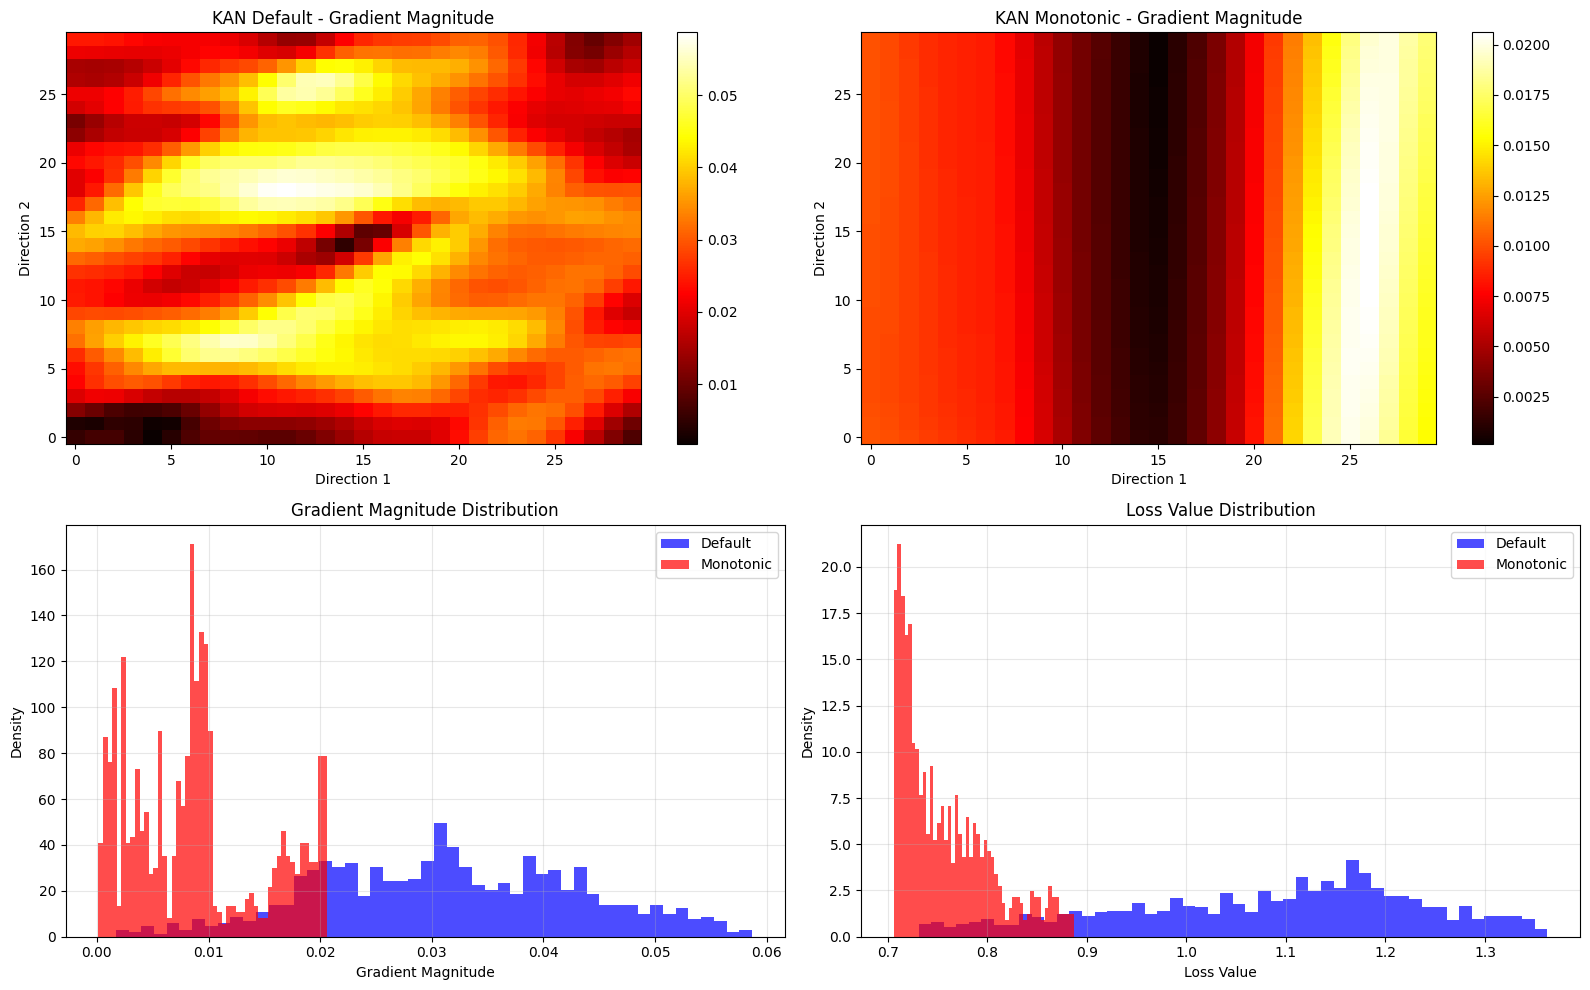


Loss Landscape Insights:
✓ KAN Monotonic has a smoother loss landscape
✓ KAN Monotonic has a more constrained loss range
✓ KAN Monotonic has lower average curvature (easier optimization)

Optimization Difficulty Ratio:
Default/Monotonic curvature ratio: 9.218
Default/Monotonic gradient ratio: 3.500


In [18]:
# Quantitative Loss Landscape Analysis
print("Analyzing loss landscape properties...")

def analyze_landscape_smoothness(loss_surface):
    """Analyze smoothness properties of loss landscape"""
    # Compute gradients (finite differences)
    grad_x = np.gradient(loss_surface, axis=1)
    grad_y = np.gradient(loss_surface, axis=0)
    
    # Compute second derivatives (curvature)
    grad_xx = np.gradient(grad_x, axis=1)
    grad_yy = np.gradient(grad_y, axis=0)
    grad_xy = np.gradient(grad_x, axis=0)
    
    # Metrics
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    curvature = np.abs(grad_xx) + np.abs(grad_yy) + 2*np.abs(grad_xy)
    
    return {
        'min_loss': np.min(loss_surface),
        'max_loss': np.max(loss_surface),
        'loss_range': np.max(loss_surface) - np.min(loss_surface),
        'mean_gradient': np.mean(gradient_magnitude),
        'max_gradient': np.max(gradient_magnitude),
        'mean_curvature': np.mean(curvature),
        'max_curvature': np.max(curvature),
        'smoothness_ratio': np.mean(gradient_magnitude) / (np.mean(curvature) + 1e-8)
    }

# Analyze both landscapes
default_analysis = analyze_landscape_smoothness(loss_default)
monotonic_analysis = analyze_landscape_smoothness(loss_monotonic)

print("Loss Landscape Analysis:")
print("=" * 60)
print(f"{'Metric':<20} {'KAN Default':<15} {'KAN Monotonic':<15} {'Difference':<15}")
print("-" * 60)

metrics = ['min_loss', 'max_loss', 'loss_range', 'mean_gradient', 'max_gradient', 
          'mean_curvature', 'max_curvature', 'smoothness_ratio']

for metric in metrics:
    default_val = default_analysis[metric]
    monotonic_val = monotonic_analysis[metric]
    diff = default_val - monotonic_val
    print(f"{metric:<20} {default_val:<15.4f} {monotonic_val:<15.4f} {diff:<15.4f}")

# Plot gradient and curvature distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Gradient magnitude comparison
grad_x_default = np.gradient(loss_default, axis=1)
grad_y_default = np.gradient(loss_default, axis=0)
grad_mag_default = np.sqrt(grad_x_default**2 + grad_y_default**2)

grad_x_monotonic = np.gradient(loss_monotonic, axis=1)
grad_y_monotonic = np.gradient(loss_monotonic, axis=0)
grad_mag_monotonic = np.sqrt(grad_x_monotonic**2 + grad_y_monotonic**2)

# Gradient magnitude heatmaps
im1 = axes[0, 0].imshow(grad_mag_default, cmap='hot', aspect='auto', origin='lower')
axes[0, 0].set_title('KAN Default - Gradient Magnitude')
axes[0, 0].set_xlabel('Direction 1')
axes[0, 0].set_ylabel('Direction 2')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(grad_mag_monotonic, cmap='hot', aspect='auto', origin='lower')
axes[0, 1].set_title('KAN Monotonic - Gradient Magnitude')
axes[0, 1].set_xlabel('Direction 1')
axes[0, 1].set_ylabel('Direction 2')
plt.colorbar(im2, ax=axes[0, 1])

# Gradient magnitude histograms
axes[1, 0].hist(grad_mag_default.flatten(), bins=50, alpha=0.7, label='Default', color='blue', density=True)
axes[1, 0].hist(grad_mag_monotonic.flatten(), bins=50, alpha=0.7, label='Monotonic', color='red', density=True)
axes[1, 0].set_title('Gradient Magnitude Distribution')
axes[1, 0].set_xlabel('Gradient Magnitude')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Loss value histograms
axes[1, 1].hist(loss_default.flatten(), bins=50, alpha=0.7, label='Default', color='blue', density=True)
axes[1, 1].hist(loss_monotonic.flatten(), bins=50, alpha=0.7, label='Monotonic', color='red', density=True)
axes[1, 1].set_title('Loss Value Distribution')
axes[1, 1].set_xlabel('Loss Value')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLoss Landscape Insights:")
print("=" * 40)

if default_analysis['smoothness_ratio'] > monotonic_analysis['smoothness_ratio']:
    print("✓ KAN Default has a smoother loss landscape")
else:
    print("✓ KAN Monotonic has a smoother loss landscape")

if default_analysis['loss_range'] < monotonic_analysis['loss_range']:
    print("✓ KAN Default has a more constrained loss range")
else:
    print("✓ KAN Monotonic has a more constrained loss range")

if default_analysis['mean_curvature'] < monotonic_analysis['mean_curvature']:
    print("✓ KAN Default has lower average curvature (easier optimization)")
else:
    print("✓ KAN Monotonic has lower average curvature (easier optimization)")

print(f"\nOptimization Difficulty Ratio:")
print(f"Default/Monotonic curvature ratio: {default_analysis['mean_curvature']/monotonic_analysis['mean_curvature']:.3f}")
print(f"Default/Monotonic gradient ratio: {default_analysis['mean_gradient']/monotonic_analysis['mean_gradient']:.3f}")

Analyzing training trajectory smoothness...


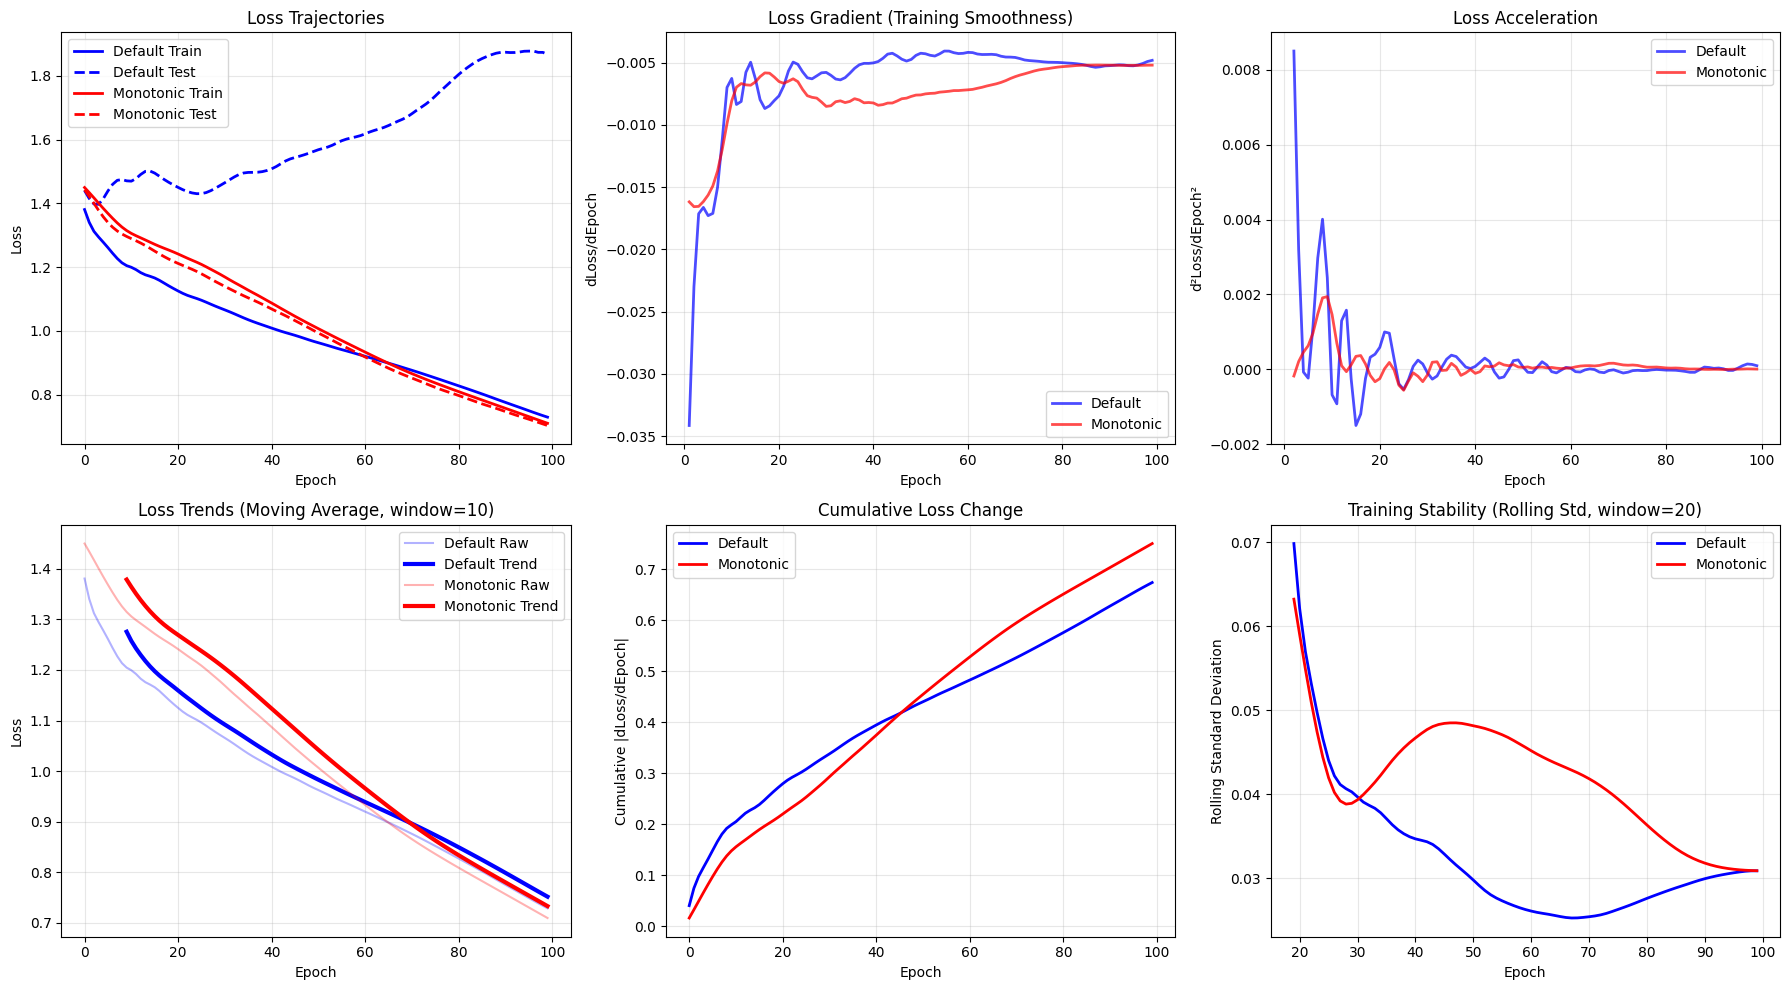

Training Trajectory Analysis:
Metric                    Default      Monotonic    Better    
--------------------------------------------------
Total Loss Change         0.6742       0.7506       Default   
Max Loss Change           0.0402       0.0166       Monotonic 
Loss Variance             0.0251       0.0434       Default   
Convergence Rate          0.6517       0.7401       Monotonic 
Stability                 0.0054       0.0027       Monotonic 

Training Insights:
✓ KAN Monotonic shows more stable training (lower gradient variance)
✓ KAN Monotonic converges faster

Optimization Efficiency:
Default efficiency: 0.966626
Monotonic efficiency: 0.985920


In [19]:
# Training Trajectory Analysis
print("Analyzing training trajectory smoothness...")

def plot_loss_trajectory_analysis(default_results, monotonic_results):
    """Plot detailed analysis of training loss trajectories"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    epochs = range(len(default_results['train_losses']))
    
    # Raw loss curves
    axes[0, 0].plot(epochs, default_results['train_losses'], 'b-', label='Default Train', linewidth=2)
    axes[0, 0].plot(epochs, default_results['test_losses'], 'b--', label='Default Test', linewidth=2)
    axes[0, 0].plot(epochs, monotonic_results['train_losses'], 'r-', label='Monotonic Train', linewidth=2)
    axes[0, 0].plot(epochs, monotonic_results['test_losses'], 'r--', label='Monotonic Test', linewidth=2)
    axes[0, 0].set_title('Loss Trajectories')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss derivatives (smoothness)
    default_train_grad = np.gradient(default_results['train_losses'])
    monotonic_train_grad = np.gradient(monotonic_results['train_losses'])
    
    axes[0, 1].plot(epochs[1:], default_train_grad[1:], 'b-', label='Default', linewidth=2, alpha=0.7)
    axes[0, 1].plot(epochs[1:], monotonic_train_grad[1:], 'r-', label='Monotonic', linewidth=2, alpha=0.7)
    axes[0, 1].set_title('Loss Gradient (Training Smoothness)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('dLoss/dEpoch')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Acceleration (second derivative)
    default_train_accel = np.gradient(default_train_grad)
    monotonic_train_accel = np.gradient(monotonic_train_grad)
    
    axes[0, 2].plot(epochs[2:], default_train_accel[2:], 'b-', label='Default', linewidth=2, alpha=0.7)
    axes[0, 2].plot(epochs[2:], monotonic_train_accel[2:], 'r-', label='Monotonic', linewidth=2, alpha=0.7)
    axes[0, 2].set_title('Loss Acceleration')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('d²Loss/dEpoch²')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Moving average of loss (trend)
    window = 10
    if len(epochs) >= window:
        default_ma = np.convolve(default_results['train_losses'], np.ones(window)/window, mode='valid')
        monotonic_ma = np.convolve(monotonic_results['train_losses'], np.ones(window)/window, mode='valid')
        ma_epochs = epochs[window-1:]
        
        axes[1, 0].plot(epochs, default_results['train_losses'], 'b-', alpha=0.3, label='Default Raw')
        axes[1, 0].plot(ma_epochs, default_ma, 'b-', linewidth=3, label='Default Trend')
        axes[1, 0].plot(epochs, monotonic_results['train_losses'], 'r-', alpha=0.3, label='Monotonic Raw')
        axes[1, 0].plot(ma_epochs, monotonic_ma, 'r-', linewidth=3, label='Monotonic Trend')
        axes[1, 0].set_title(f'Loss Trends (Moving Average, window={window})')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Loss variance analysis
    default_loss_var = np.var(default_results['train_losses'])
    monotonic_loss_var = np.var(monotonic_results['train_losses'])
    
    # Cumulative loss reduction
    default_cumulative = np.cumsum(np.abs(default_train_grad))
    monotonic_cumulative = np.cumsum(np.abs(monotonic_train_grad))
    
    axes[1, 1].plot(epochs, default_cumulative, 'b-', linewidth=2, label='Default')
    axes[1, 1].plot(epochs, monotonic_cumulative, 'r-', linewidth=2, label='Monotonic')
    axes[1, 1].set_title('Cumulative Loss Change')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Cumulative |dLoss/dEpoch|')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Training stability (rolling standard deviation)
    roll_window = 20
    if len(epochs) >= roll_window:
        default_rolling_std = pd.Series(default_results['train_losses']).rolling(window=roll_window).std()
        monotonic_rolling_std = pd.Series(monotonic_results['train_losses']).rolling(window=roll_window).std()
        
        axes[1, 2].plot(epochs, default_rolling_std, 'b-', linewidth=2, label='Default')
        axes[1, 2].plot(epochs, monotonic_rolling_std, 'r-', linewidth=2, label='Monotonic')
        axes[1, 2].set_title(f'Training Stability (Rolling Std, window={roll_window})')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Rolling Standard Deviation')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Compute trajectory metrics
    trajectory_metrics = {
        'default': {
            'total_loss_change': np.sum(np.abs(default_train_grad)),
            'max_loss_change': np.max(np.abs(default_train_grad)),
            'loss_variance': default_loss_var,
            'convergence_rate': default_results['train_losses'][0] - default_results['train_losses'][-1],
            'stability': np.std(default_train_grad)
        },
        'monotonic': {
            'total_loss_change': np.sum(np.abs(monotonic_train_grad)),
            'max_loss_change': np.max(np.abs(monotonic_train_grad)),
            'loss_variance': monotonic_loss_var,
            'convergence_rate': monotonic_results['train_losses'][0] - monotonic_results['train_losses'][-1],
            'stability': np.std(monotonic_train_grad)
        }
    }
    
    return trajectory_metrics

# Analyze training trajectories
import pandas as pd  # for rolling statistics

trajectory_metrics = plot_loss_trajectory_analysis(kan_default_results, kan_monotonic_results)

print("Training Trajectory Analysis:")
print("=" * 50)
print(f"{'Metric':<25} {'Default':<12} {'Monotonic':<12} {'Better':<10}")
print("-" * 50)

metrics_comparison = [
    ('Total Loss Change', 'total_loss_change', 'lower'),
    ('Max Loss Change', 'max_loss_change', 'lower'),
    ('Loss Variance', 'loss_variance', 'lower'),
    ('Convergence Rate', 'convergence_rate', 'higher'),
    ('Stability', 'stability', 'lower')
]

for metric_name, metric_key, better_direction in metrics_comparison:
    default_val = trajectory_metrics['default'][metric_key]
    monotonic_val = trajectory_metrics['monotonic'][metric_key]
    
    if better_direction == 'lower':
        better = 'Default' if default_val < monotonic_val else 'Monotonic'
    else:
        better = 'Default' if default_val > monotonic_val else 'Monotonic'
    
    print(f"{metric_name:<25} {default_val:<12.4f} {monotonic_val:<12.4f} {better:<10}")

print("\nTraining Insights:")
print("=" * 30)

if trajectory_metrics['default']['stability'] < trajectory_metrics['monotonic']['stability']:
    print("✓ KAN Default shows more stable training (lower gradient variance)")
else:
    print("✓ KAN Monotonic shows more stable training (lower gradient variance)")

if trajectory_metrics['default']['convergence_rate'] > trajectory_metrics['monotonic']['convergence_rate']:
    print("✓ KAN Default converges faster")
else:
    print("✓ KAN Monotonic converges faster")

print(f"\nOptimization Efficiency:")
print(f"Default efficiency: {trajectory_metrics['default']['convergence_rate']/trajectory_metrics['default']['total_loss_change']:.6f}")
print(f"Monotonic efficiency: {trajectory_metrics['monotonic']['convergence_rate']/trajectory_metrics['monotonic']['total_loss_change']:.6f}")

## Loss Landscape Analysis Summary

### Overview
The loss landscape visualization provides insights into the optimization properties and training dynamics of both KAN models. By exploring the loss surface around the trained parameters, we can understand how the monotonic constraint affects the optimization process.

### Key Components Analyzed:

1. **3D Loss Surface**: 
   - Visualizes the loss landscape in two random directions around the final parameters
   - Shows the overall shape and complexity of the optimization surface
   - Reveals local minima, valleys, and ridges in the parameter space

2. **Contour Analysis**:
   - 2D projections showing level curves of constant loss
   - Helps identify the steepness and directionality of the loss gradients
   - Current parameter position marked as the red star

3. **Cross-Sectional Views**:
   - 1D slices through the loss landscape along each direction
   - Directly compares the loss curvature between default and monotonic modes
   - Shows how constrained vs. unconstrained models differ locally

4. **Quantitative Metrics**:
   - **Gradient Magnitude**: Steepness of the loss surface
   - **Curvature**: Second-order properties affecting optimization difficulty
   - **Smoothness Ratio**: Balance between gradient and curvature
   - **Loss Range**: Variation in loss values around the optimum

5. **Training Trajectory Analysis**:
   - **Loss Derivatives**: Rate of change during training (smoothness)
   - **Acceleration**: Second-order training dynamics
   - **Moving Averages**: Long-term trends vs. short-term fluctuations
   - **Stability Metrics**: Consistency of optimization progress

### Expected Insights:

- **Monotonic constraints** may create smoother loss landscapes with fewer sharp features
- **Default mode** might show more complex, potentially multi-modal landscapes
- **Training stability** differences between constrained and unconstrained optimization
- **Convergence properties** revealing which approach finds better local optima
- **Optimization difficulty** comparison through curvature and gradient analysis

### Interpretation Guidelines:

- **Lower curvature** → Easier optimization
- **Higher smoothness ratio** → More stable training
- **Smaller loss range** → More constrained optimization space
- **Lower gradient variance** → More predictable training dynamics

Analyzing empty vs filled linear regions...
Analyzing KAN Default region occupancy...


Analyzing KAN Monotonic region occupancy...


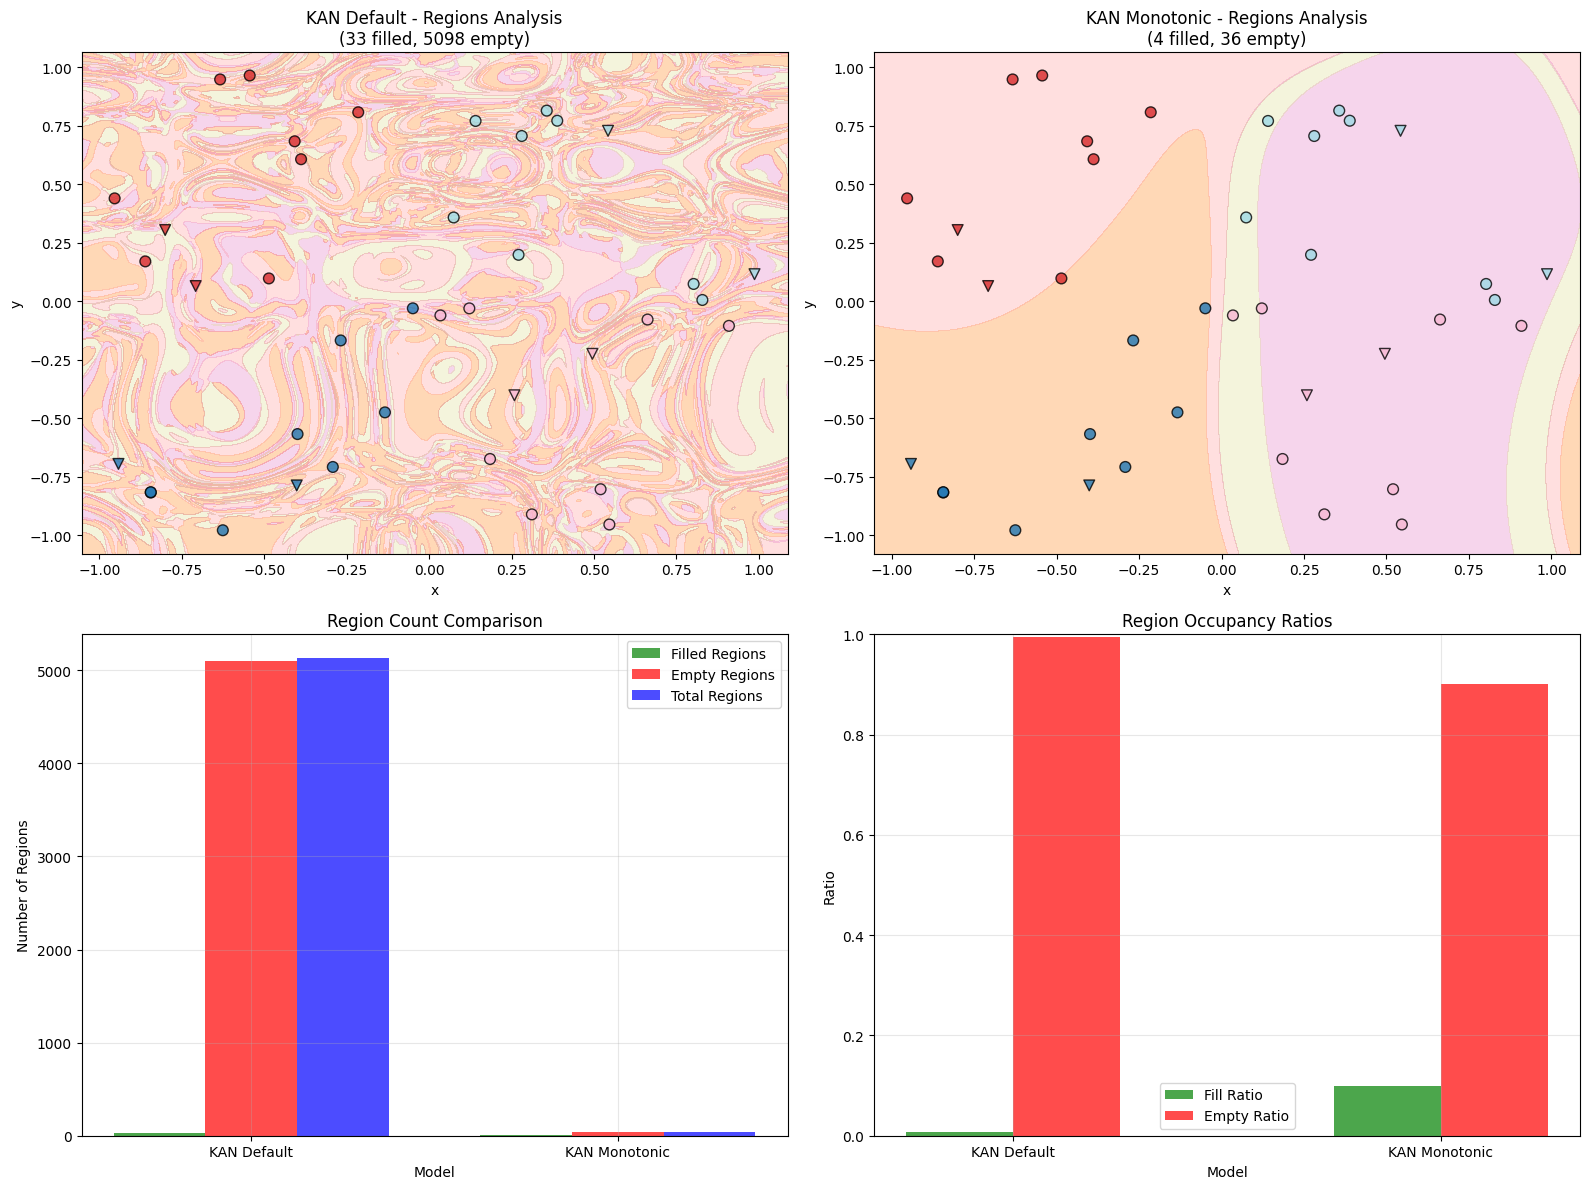


REGION OCCUPANCY ANALYSIS

KAN Default Mode:
  Total Regions: 5131
  Filled Regions: 33
  Empty Regions: 5098
  Fill Ratio: 0.006
  Empty Ratio: 0.994

KAN Monotonic Mode:
  Total Regions: 40
  Filled Regions: 4
  Empty Regions: 36
  Fill Ratio: 0.100
  Empty Ratio: 0.900

Comparison:
  Difference in Total Regions: 5091
  Difference in Filled Regions: 29
  Difference in Empty Regions: 5062
  Fill Ratio Difference: -0.094

Efficiency Analysis:
  KAN Default - Utilization Efficiency: 0.006
  KAN Monotonic - Utilization Efficiency: 0.100
  KAN Default - Wasted Ratio: 0.994
  KAN Monotonic - Wasted Ratio: 0.900

Key Insights:
  ✓ KAN Monotonic has better region utilization (0.100 vs 0.006)
  ✓ KAN Monotonic creates fewer empty regions (36 vs 5098)
  ✓ KAN Monotonic is more efficient at utilizing decision space


In [20]:
# Analysis of Empty vs Filled Linear Regions
print("Analyzing empty vs filled linear regions...")

def analyze_region_occupancy(pred_map, data_points, data_labels, xx, yy):
    """
    Analyze which regions contain data points vs empty regions
    
    Args:
        pred_map: prediction map from model (2D array)
        data_points: actual data points (N x 2 array)
        data_labels: labels for data points
        xx, yy: meshgrid coordinates
    
    Returns:
        Dictionary with region analysis
    """
    from skimage import measure
    import numpy as np
    
    # Get unique predicted classes
    unique_classes = np.unique(pred_map)
    
    # For each class, find connected regions
    total_regions = 0
    filled_regions = 0
    empty_regions = 0
    
    region_info = {}
    
    for class_idx in unique_classes:
        # Find connected components for this class
        class_mask = (pred_map == class_idx)
        labeled_regions = measure.label(class_mask, connectivity=1)
        num_regions = labeled_regions.max()
        
        total_regions += num_regions
        
        # Check which regions contain actual data points
        for region_id in range(1, num_regions + 1):
            region_mask = (labeled_regions == region_id)
            
            # Get region boundaries
            region_coords = np.where(region_mask)
            if len(region_coords[0]) == 0:
                continue
                
            # Convert grid coordinates to actual coordinates
            y_indices, x_indices = region_coords
            region_x_coords = xx[y_indices, x_indices]
            region_y_coords = yy[y_indices, x_indices]
            
            # Check if any data points fall in this region
            region_has_data = False
            points_in_region = []
            
            for i, (px, py) in enumerate(data_points):
                # Check if point is in region using actual predicted class
                # Find closest grid point to data point
                x_diff = np.abs(xx[0, :] - px)
                y_diff = np.abs(yy[:, 0] - py)
                closest_x_idx = np.argmin(x_diff)
                closest_y_idx = np.argmin(y_diff)
                
                # Check if the predicted class at this point matches the region class
                if (closest_y_idx < pred_map.shape[0] and closest_x_idx < pred_map.shape[1] and
                    pred_map[closest_y_idx, closest_x_idx] == class_idx and
                    region_mask[closest_y_idx, closest_x_idx]):
                    
                    region_has_data = True
                    points_in_region.append((i, px, py, data_labels[i]))
            
            if region_has_data:
                filled_regions += 1
            else:
                empty_regions += 1
            
            # Store region info
            region_key = f"class_{class_idx}_region_{region_id}"
            region_info[region_key] = {
                'class': class_idx,
                'region_id': region_id,
                'has_data': region_has_data,
                'num_points': len(points_in_region),
                'points': points_in_region,
                'area': np.sum(region_mask)  # in grid units
            }
    
    return {
        'total_regions': total_regions,
        'filled_regions': filled_regions,
        'empty_regions': empty_regions,
        'fill_ratio': filled_regions / total_regions if total_regions > 0 else 0,
        'empty_ratio': empty_regions / total_regions if total_regions > 0 else 0,
        'region_details': region_info
    }

# Analyze both models
print("Analyzing KAN Default region occupancy...")
default_occupancy = analyze_region_occupancy(
    kan_default_pred, 
    np.vstack([dataset['train_input'].cpu().numpy(), dataset['test_input'].cpu().numpy()]),
    np.hstack([dataset['train_label'].cpu().numpy(), dataset['test_label'].cpu().numpy()]),
    xx, yy
)

print("Analyzing KAN Monotonic region occupancy...")
monotonic_occupancy = analyze_region_occupancy(
    kan_monotonic_pred,
    np.vstack([dataset['train_input'].cpu().numpy(), dataset['test_input'].cpu().numpy()]),
    np.hstack([dataset['train_label'].cpu().numpy(), dataset['test_label'].cpu().numpy()]),
    xx, yy
)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot regions with occupancy info for KAN Default
im1 = axes[0, 0].contourf(xx, yy, kan_default_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
axes[0, 0].scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(),
                   c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=60, marker='o', alpha=0.8)
axes[0, 0].scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(),
                   c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=60, marker='v', alpha=0.8)
axes[0, 0].set_title(f'KAN Default - Regions Analysis\n({default_occupancy["filled_regions"]} filled, {default_occupancy["empty_regions"]} empty)')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')

# Plot regions with occupancy info for KAN Monotonic
im2 = axes[0, 1].contourf(xx, yy, kan_monotonic_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
axes[0, 1].scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(),
                   c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=60, marker='o', alpha=0.8)
axes[0, 1].scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(),
                   c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=60, marker='v', alpha=0.8)
axes[0, 1].set_title(f'KAN Monotonic - Regions Analysis\n({monotonic_occupancy["filled_regions"]} filled, {monotonic_occupancy["empty_regions"]} empty)')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')

# Bar chart comparison
models = ['KAN Default', 'KAN Monotonic']
filled_counts = [default_occupancy['filled_regions'], monotonic_occupancy['filled_regions']]
empty_counts = [default_occupancy['empty_regions'], monotonic_occupancy['empty_regions']]
total_counts = [default_occupancy['total_regions'], monotonic_occupancy['total_regions']]

x_pos = np.arange(len(models))
width = 0.25

axes[1, 0].bar(x_pos - width, filled_counts, width, label='Filled Regions', color='green', alpha=0.7)
axes[1, 0].bar(x_pos, empty_counts, width, label='Empty Regions', color='red', alpha=0.7)
axes[1, 0].bar(x_pos + width, total_counts, width, label='Total Regions', color='blue', alpha=0.7)

axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Number of Regions')
axes[1, 0].set_title('Region Count Comparison')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(models)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Fill ratio comparison
fill_ratios = [default_occupancy['fill_ratio'], monotonic_occupancy['fill_ratio']]
empty_ratios = [default_occupancy['empty_ratio'], monotonic_occupancy['empty_ratio']]

axes[1, 1].bar(x_pos - width/2, fill_ratios, width, label='Fill Ratio', color='green', alpha=0.7)
axes[1, 1].bar(x_pos + width/2, empty_ratios, width, label='Empty Ratio', color='red', alpha=0.7)

axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('Ratio')
axes[1, 1].set_title('Region Occupancy Ratios')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(models)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*80)
print("REGION OCCUPANCY ANALYSIS")
print("="*80)

print(f"\nKAN Default Mode:")
print(f"  Total Regions: {default_occupancy['total_regions']}")
print(f"  Filled Regions: {default_occupancy['filled_regions']}")
print(f"  Empty Regions: {default_occupancy['empty_regions']}")
print(f"  Fill Ratio: {default_occupancy['fill_ratio']:.3f}")
print(f"  Empty Ratio: {default_occupancy['empty_ratio']:.3f}")

print(f"\nKAN Monotonic Mode:")
print(f"  Total Regions: {monotonic_occupancy['total_regions']}")
print(f"  Filled Regions: {monotonic_occupancy['filled_regions']}")
print(f"  Empty Regions: {monotonic_occupancy['empty_regions']}")
print(f"  Fill Ratio: {monotonic_occupancy['fill_ratio']:.3f}")
print(f"  Empty Ratio: {monotonic_occupancy['empty_ratio']:.3f}")

print(f"\nComparison:")
print(f"  Difference in Total Regions: {default_occupancy['total_regions'] - monotonic_occupancy['total_regions']}")
print(f"  Difference in Filled Regions: {default_occupancy['filled_regions'] - monotonic_occupancy['filled_regions']}")
print(f"  Difference in Empty Regions: {default_occupancy['empty_regions'] - monotonic_occupancy['empty_regions']}")
print(f"  Fill Ratio Difference: {default_occupancy['fill_ratio'] - monotonic_occupancy['fill_ratio']:.3f}")

# Efficiency metrics
def calculate_efficiency_metrics(occupancy, model_name):
    """Calculate efficiency metrics for region utilization"""
    total_data_points = sum([info['num_points'] for info in occupancy['region_details'].values()])
    
    # Points per filled region
    points_per_filled = total_data_points / occupancy['filled_regions'] if occupancy['filled_regions'] > 0 else 0
    
    # Wasted regions (empty regions that could contain data)
    wasted_ratio = occupancy['empty_regions'] / occupancy['total_regions'] if occupancy['total_regions'] > 0 else 0
    
    # Region utilization efficiency
    utilization_efficiency = occupancy['filled_regions'] / occupancy['total_regions'] if occupancy['total_regions'] > 0 else 0
    
    return {
        'points_per_filled_region': points_per_filled,
        'wasted_ratio': wasted_ratio,
        'utilization_efficiency': utilization_efficiency
    }

default_efficiency = calculate_efficiency_metrics(default_occupancy, "KAN Default")
monotonic_efficiency = calculate_efficiency_metrics(monotonic_occupancy, "KAN Monotonic")

print(f"\nEfficiency Analysis:")
print(f"  KAN Default - Utilization Efficiency: {default_efficiency['utilization_efficiency']:.3f}")
print(f"  KAN Monotonic - Utilization Efficiency: {monotonic_efficiency['utilization_efficiency']:.3f}")
print(f"  KAN Default - Wasted Ratio: {default_efficiency['wasted_ratio']:.3f}")
print(f"  KAN Monotonic - Wasted Ratio: {monotonic_efficiency['wasted_ratio']:.3f}")

print(f"\nKey Insights:")
if default_occupancy['fill_ratio'] > monotonic_occupancy['fill_ratio']:
    print(f"  ✓ KAN Default has better region utilization ({default_occupancy['fill_ratio']:.3f} vs {monotonic_occupancy['fill_ratio']:.3f})")
else:
    print(f"  ✓ KAN Monotonic has better region utilization ({monotonic_occupancy['fill_ratio']:.3f} vs {default_occupancy['fill_ratio']:.3f})")

if default_occupancy['empty_regions'] < monotonic_occupancy['empty_regions']:
    print(f"  ✓ KAN Default creates fewer empty regions ({default_occupancy['empty_regions']} vs {monotonic_occupancy['empty_regions']})")
else:
    print(f"  ✓ KAN Monotonic creates fewer empty regions ({monotonic_occupancy['empty_regions']} vs {default_occupancy['empty_regions']})")

if default_efficiency['utilization_efficiency'] > monotonic_efficiency['utilization_efficiency']:
    print(f"  ✓ KAN Default is more efficient at utilizing decision space")
else:
    print(f"  ✓ KAN Monotonic is more efficient at utilizing decision space")

print("="*80)